# Using the Qiskit compiler

<p>
<font size=4 color="#0f62fe">IBM Quantum Partner Technical Enablement Team</font>
<p>

## Overview

Here we will cover how to use the Qiskit compiler to the best extent possible for most common use cases.  As things change frequently, please see the version numbers at the bottom of the notebook to see which version of Qiskit was used in generating the results presented here.  Those interested in just getting a quick summary of the material presented here may do so in the next section.

## Summary

Although there are a myriad of compilation options in Qiskit, for a given quantum circuit `qc` and target system called `backend`, the `transpile` function should be called with the `optimization_level=3` setting on Qiskit 0.19+:

```python
trans_qc = transpile(qc, backend, optimization_level=3)
```

Additionally, due to the stochastic nature of the SWAP mappers in Qiskit, ideally one should `transpile` multiple copies of a circuit and take the one with the lowest depth (`qc.depth()`).  Users should also explore mapping their circuits to the target system by hand via setting of the `initial_layout` option in `transpile` to best match the topology of the device and it error characteristics.  At this stage compiler maturity smart hand-mapping generally beats automated layout methods.

## Frontmatter

Here we load the modules needed for the rest of the notebook, as well as our locally stored IBM Quantum account.

In [1]:
import numpy as np
from qiskit import *

%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
#plt.style.use('ibmq-dark')

In [2]:
IBMQ.load_account();

## Circuit compilation

To understand hwo the compiler works we will consider a six-qubit GHZ state writen so that a single-qubit requires $5$-partite connectivity; outside the maximum Heavy-hex topology connectivity of 3.  Thus this circuit will require swap gates to satisfy the topology constraints.

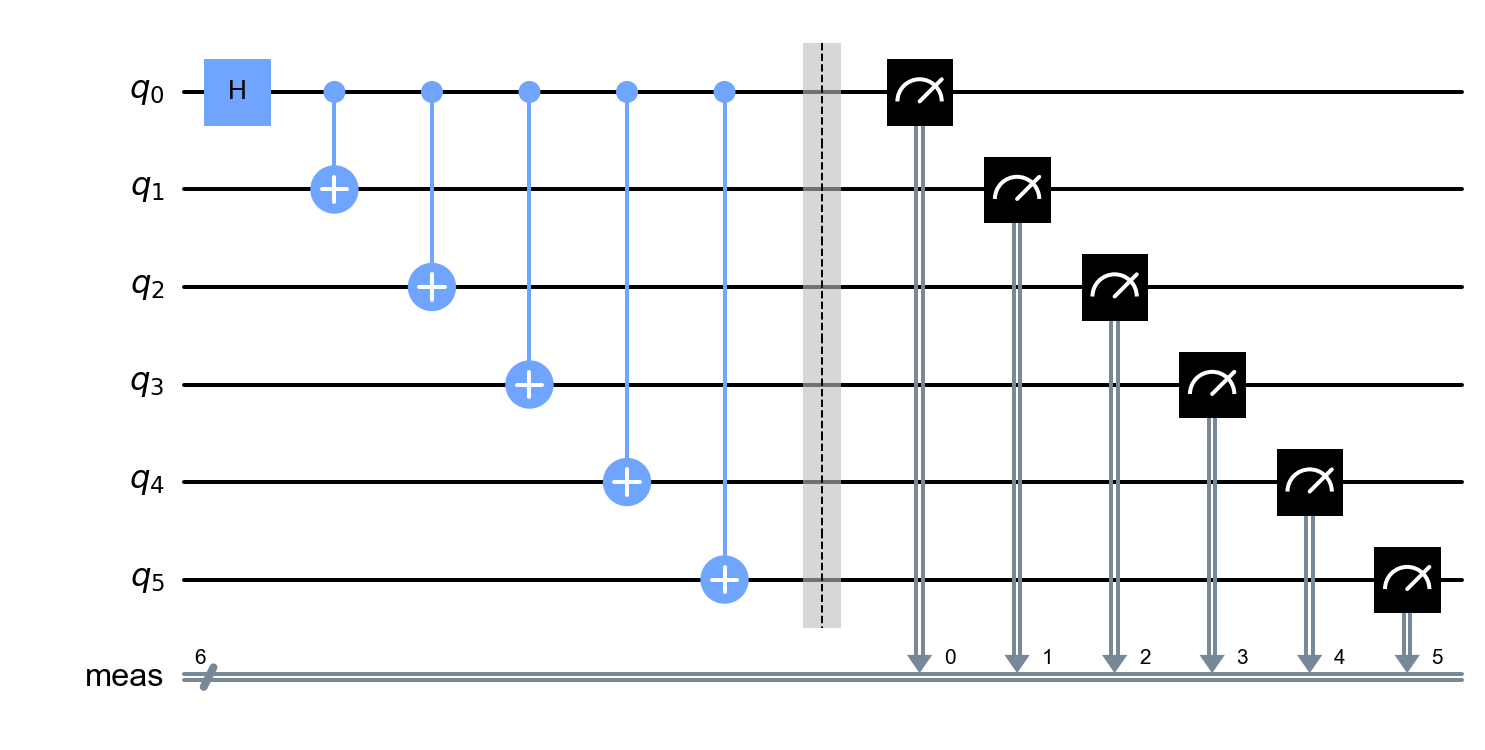

In [3]:
N = 6
qc = QuantumCircuit(N)
qc.h(0)
qc.cx(0,range(1, N))
qc.measure_all()
qc.draw('mpl')

Lets select our target 27Q system:

In [4]:
provider = IBMQ.get_provider(group='deployed')
backend = provider.backend.ibmq_mumbai

### Basic circuit transpilation

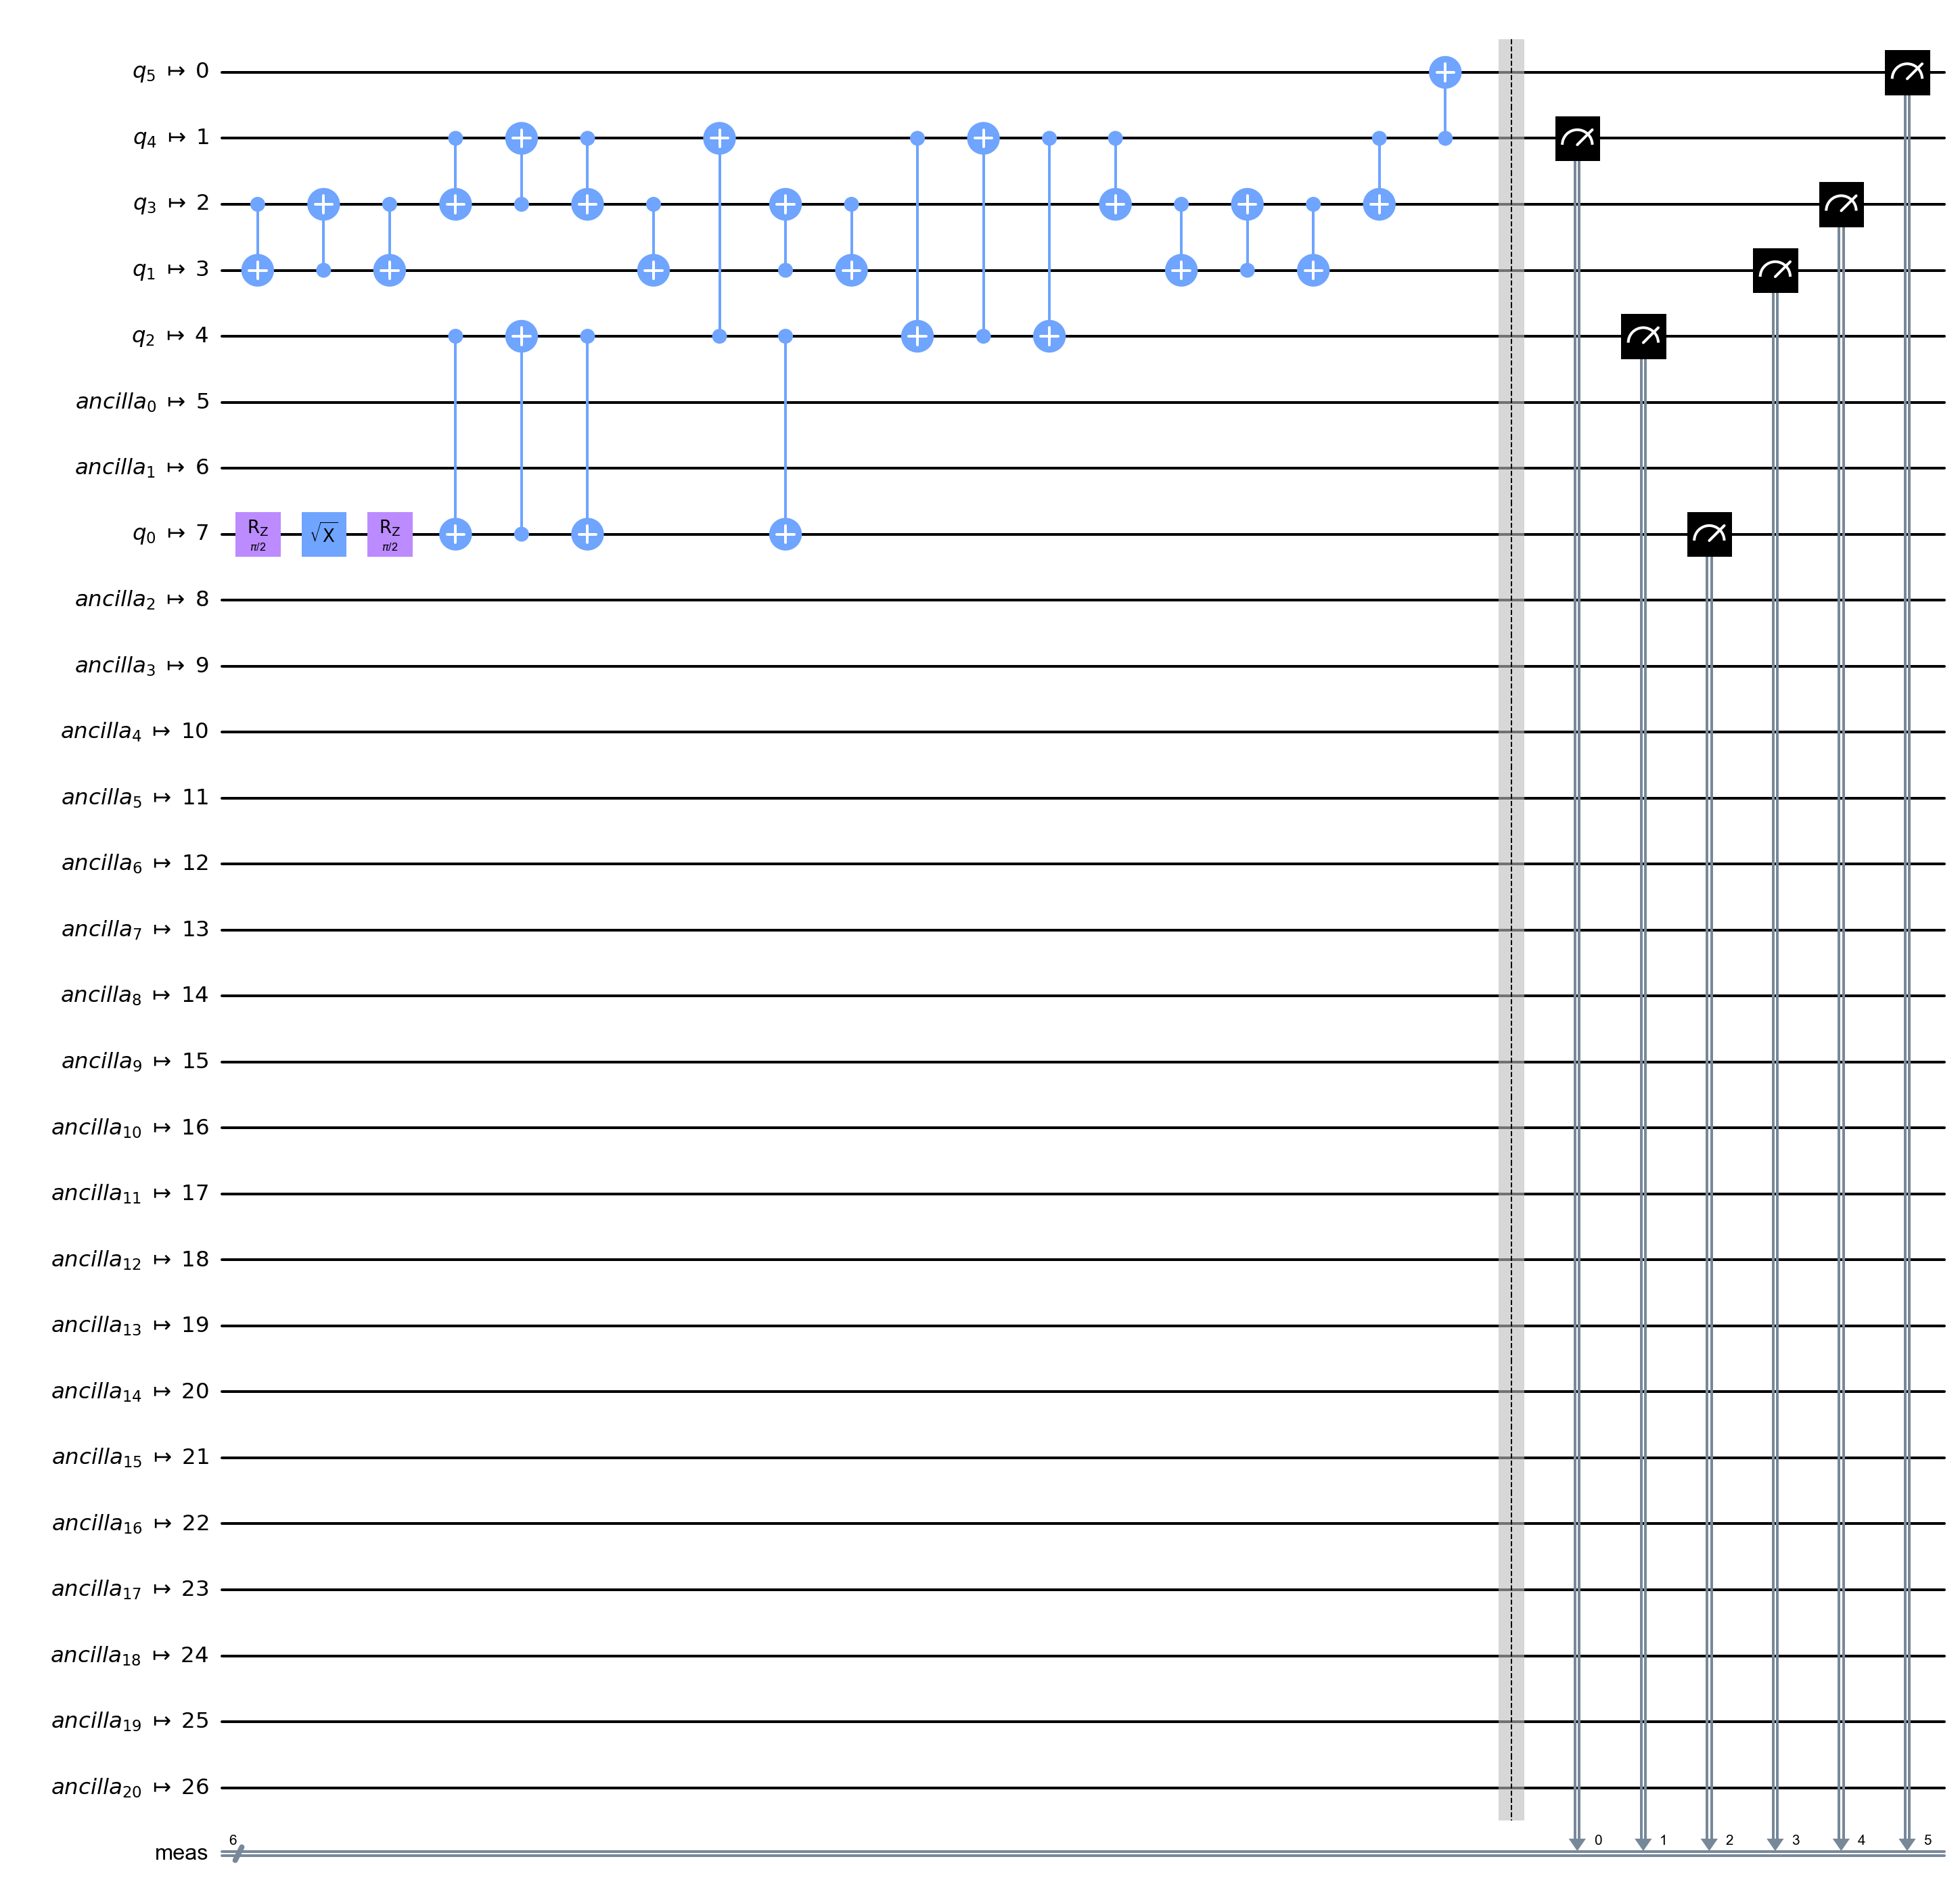

In [5]:
trans_qc = transpile(qc, backend)
trans_qc.draw('mpl', fold=-1)

Things to note:

1. Obviously, the circuit now contains as many qubits as the target system.

    
2. Our qubits have been mapped to physical qubits and have been permuted at the beginning.


3. Our `H` gate has been re-written as a collection of three 1Q gates.


4. The number of CNOT gates has increased, in particular there are groups of three CNOT gates added to the circuit.


5. The measurements are again permuted from where one expects them to be based on the initial qubit ordering.

What your circuit looks like above is likely different from the one shown here.  This is because some parts of the transpilation route are stochastic; they contain algorithms that rely on pseudorandom number generation.  To see this lets `transpile` the same circuit again (may have to do more than once since it is random):

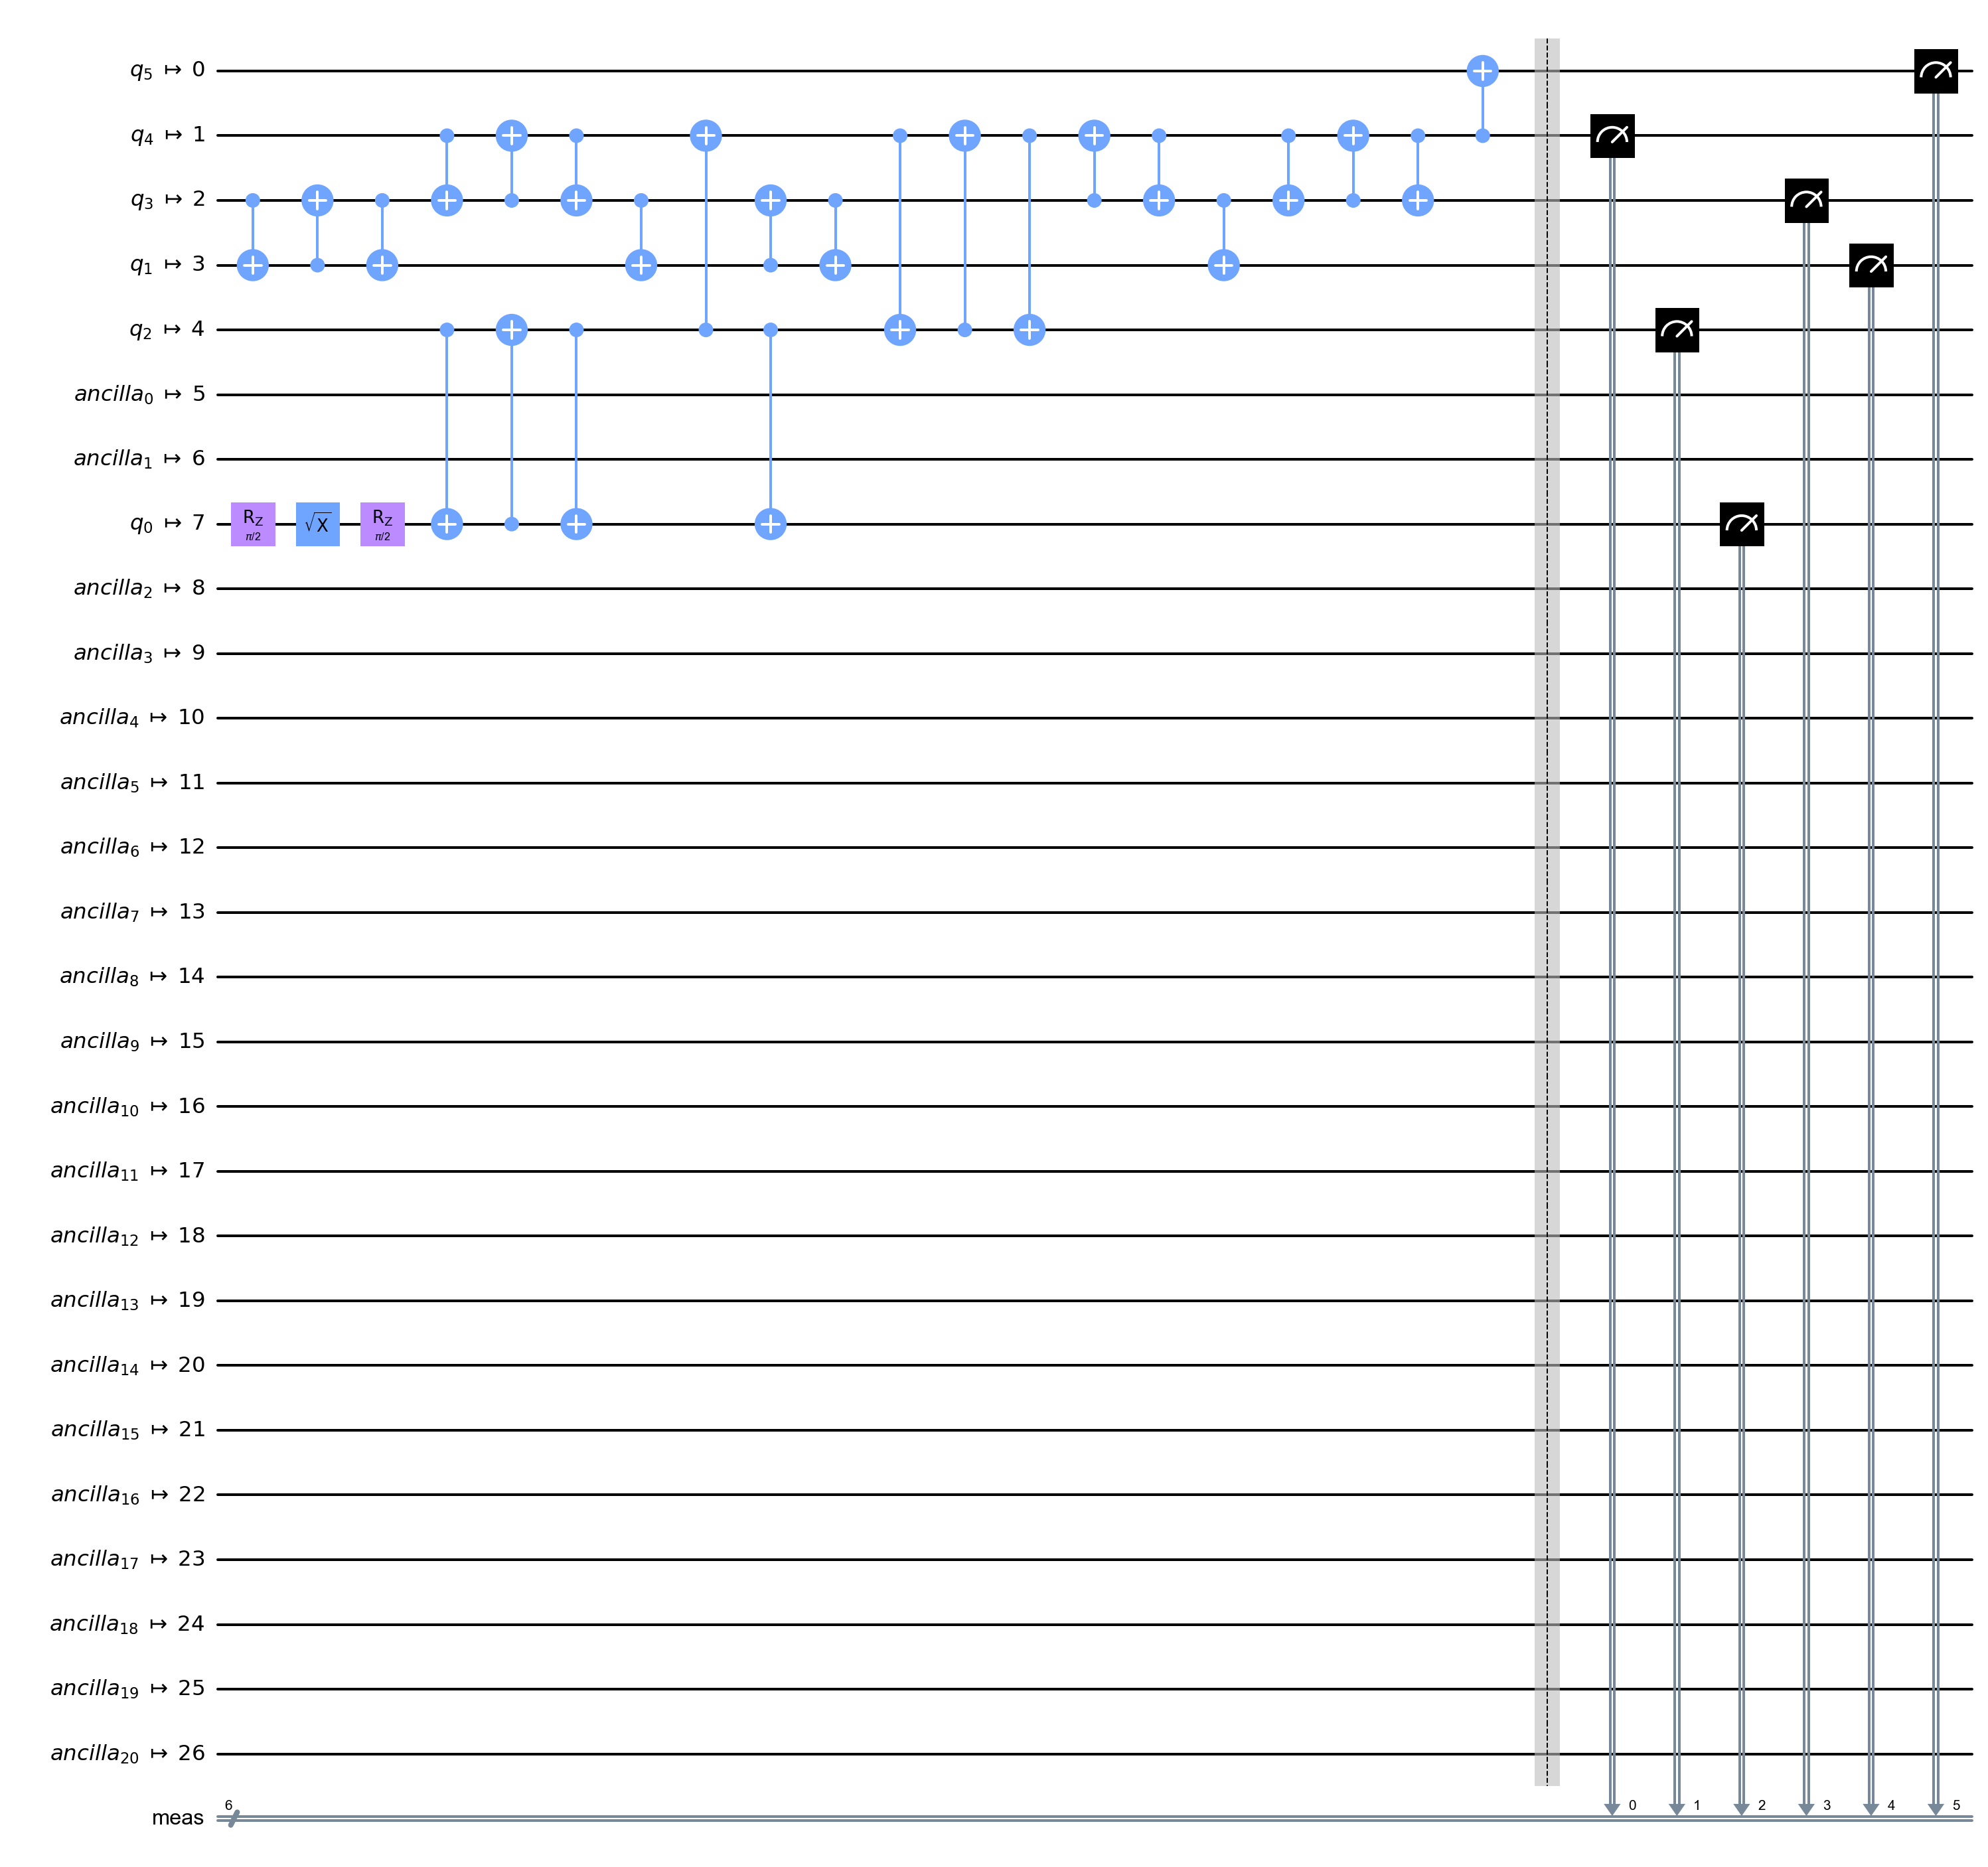

In [6]:
trans_qc = transpile(qc, backend)
trans_qc.draw('mpl', fold=-1)

## Basic compilation pipeline

Compilation, in it simplest form, involves the following steps:

1. Express circuit in terms of systems native gate set.


2. Select the intial virtual to physical qubit mapping.


3. Add SWAP gates to circuit to satisfy topology.


4. Optimize 1Q and 2Q gates.

### System basis gates

Quantum computation greatly benefits from the fact that any computation can be written in terms of polynomial numbers of gates selected from a universal gate set that itself is comprised of a finite number of elements.  This "digitizes" the computation into successive steps.  Alternatives are a "pulse" based, continuous evolution, or ideally, going from initial to final state in a single step by forming the exact desired unitary.  This latter option is rarely, if ever, acheivable do to physical constraints, amonst other complications.

<img src="imgs/propagate.png" width=500 height=400 />

In Qiskit, universal gate sets are called `basis_gates`, and in general are over-complete sets. The `basis_gates` for IBM Quantum systems are found in the `backend.configuration()`

In [7]:
backend.configuration().basis_gates

['id', 'rz', 'sx', 'x', 'cx', 'reset']

A few things to note:

1. For 1Q gates, IBM Quantum systems can only do `sx` ($\sqrt{x}$) and `x` gates, along with arbitrary z-axis rotations via `rz`.


2. All z-rotations are "virtual" gates; there is no rotations of the qubits.  All z-rotations get mapped to phase-angles that get applied to all gates that come later.


3. The `sx` and `x` gates take the same amount of time to impliment; they differ by the amplitude of the underlying pulse that causes the rotation.


4. Currently, the only 2Q gate is the `cx` (CNOT) gate.  This will be relaxed in the future to expose native `cr` (cross-resonance) gates.


5.  On IBM Quantum systems, the identity gate `id` currently is represented as an idle time of the same width as an `sx` gate.  


6.  `reset` is not actually a gate (non-unitary) but is here due to legacy implimentation issues.

In our GHZ circuit the `h` gate got converted into a single `sx` gate and two `rz` rotations:

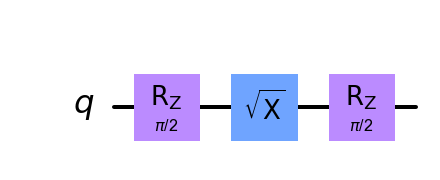

In [8]:
qc_1q = QuantumCircuit(1)
qc_1q.h(0)
transpile(qc_1q, basis_gates=backend.configuration().basis_gates).draw('mpl')

For a generic 1Q gate, the worst-case decomposition is comprised of two `sx` gates and three virtual `rz` rotations of various anagles:

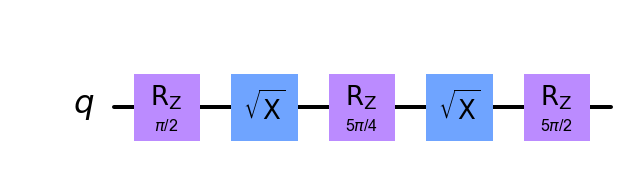

In [9]:
qc_1q = QuantumCircuit(1)
qc_1q.rx(np.pi/4, 0)
transpile(qc_1q, basis_gates=backend.configuration().basis_gates).draw('mpl')

### Initial qubit layout

The qubits in a ciruit are "virtual" qubits in that they exist in abstract only.  To perform the actual computation we must must map these virtual qubits onto the physical qubits of the target quantum system.  There is no unique way to do this, the mapping need only be bijective, and the choice of `initial_layout` can greatly affect the performance of later SWAP mapping, as well as overall fidelity is the selected qubits are overly error prone.

<img src="imgs/mapping.png" width=800 height=400 />

#### Setting `initial_layout`

Qiskit will automatically pick an `initial_layout` for you.  The choice of layout depends on the `optimization_level` chosen (default is `optimization_level=1`, as well as additional configuration options.  We will discuss `optimization_level` later, and instead focus on how to manually set the `initial_layout`.  Often times it is best to do so after looking at the calibration data to select the qubits with lowest 1Q errors, measurement errors, and associated `cx` gate errors.

The calibration data can easily be found on the IBM Quantum  website, e.g. [Mumbai calibration data](https://quantum-computing.ibm.com/services?services=systems&system=ibmq_mumbai).  Alternatively, it can be found via Qiskit.

The initial virtual -> physical mapping can be manually set using the `initial_layout` argument in `transpile`.  This variable takes a list, amongst other options, where the 0th element tells the transpiler which physical qubit to map virtual qubit 0 to, etc.


Because virtual qubit 0 needs large amounts of connectivity lets map it to physical qubit 1, and then select the other qubits so that they are nearest neighboor as possible.

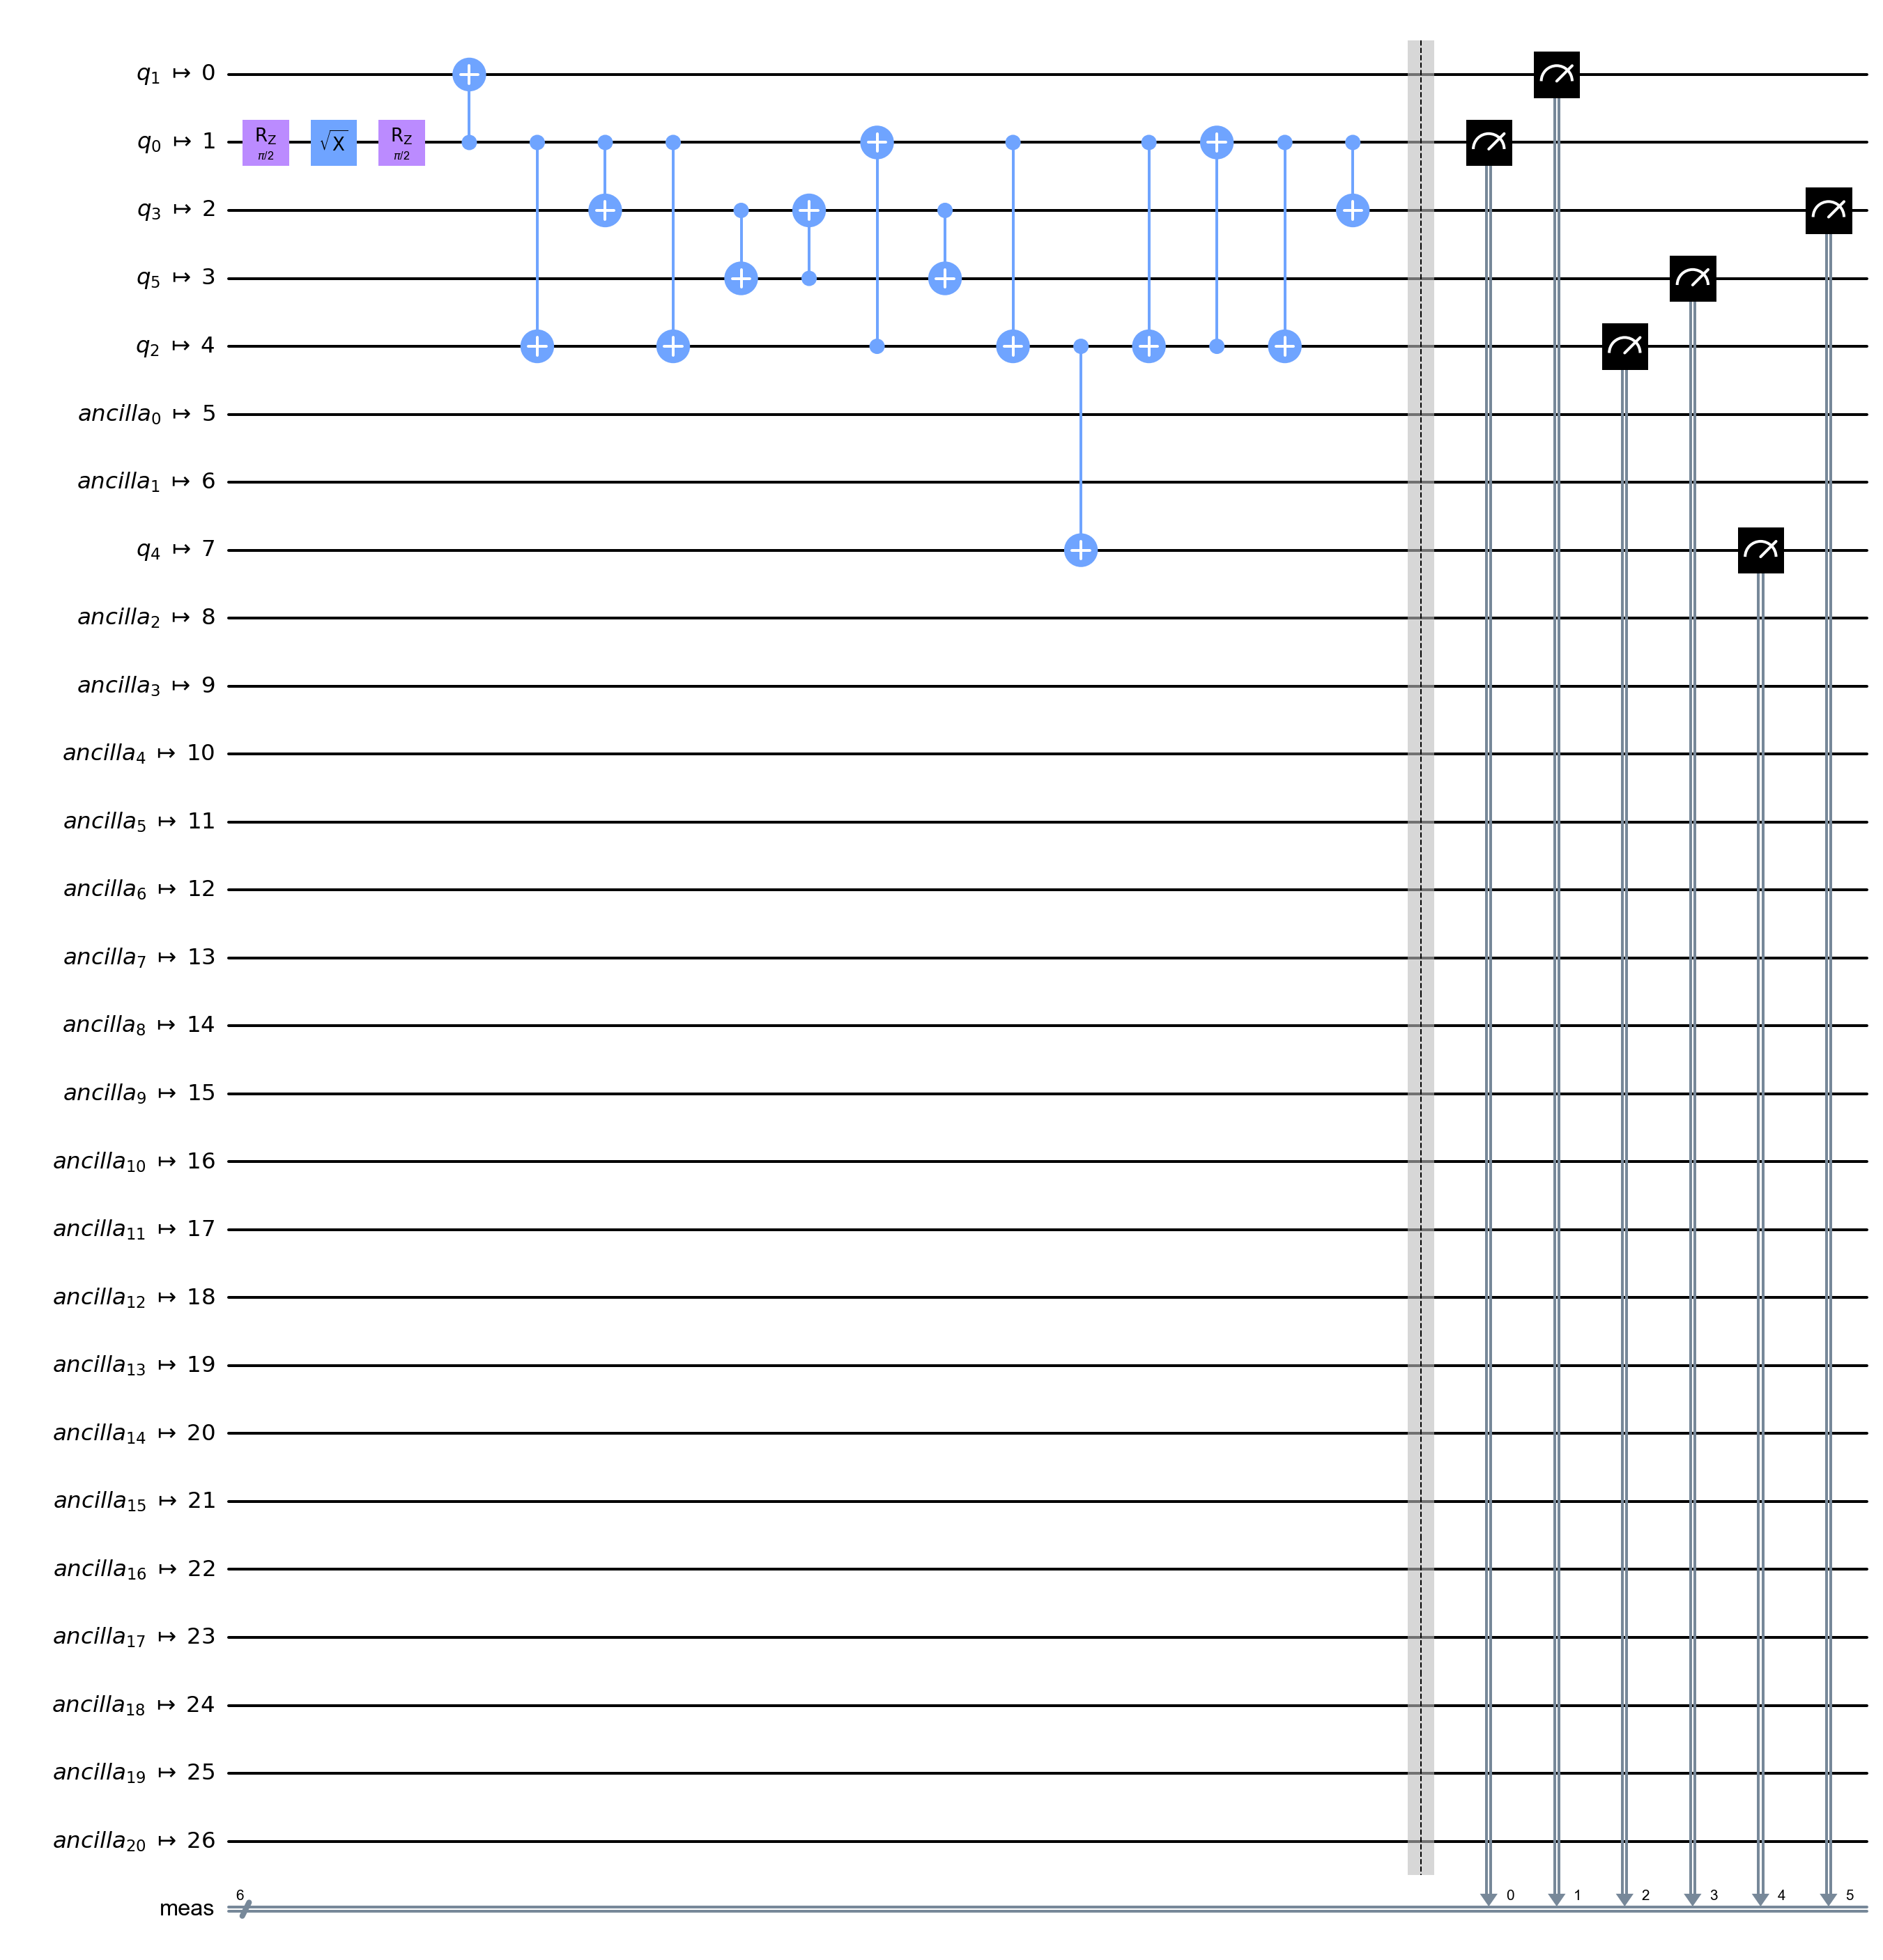

In [10]:
trans_qc = transpile(qc, backend, initial_layout=[1, 0, 4, 2, 7, 3])
trans_qc.draw('mpl', fold=-1)

We are also free to pick disjoint sets of physical qubits.  This is usually not a good idea but none the less can be done.  Here is a particularly bad choice:

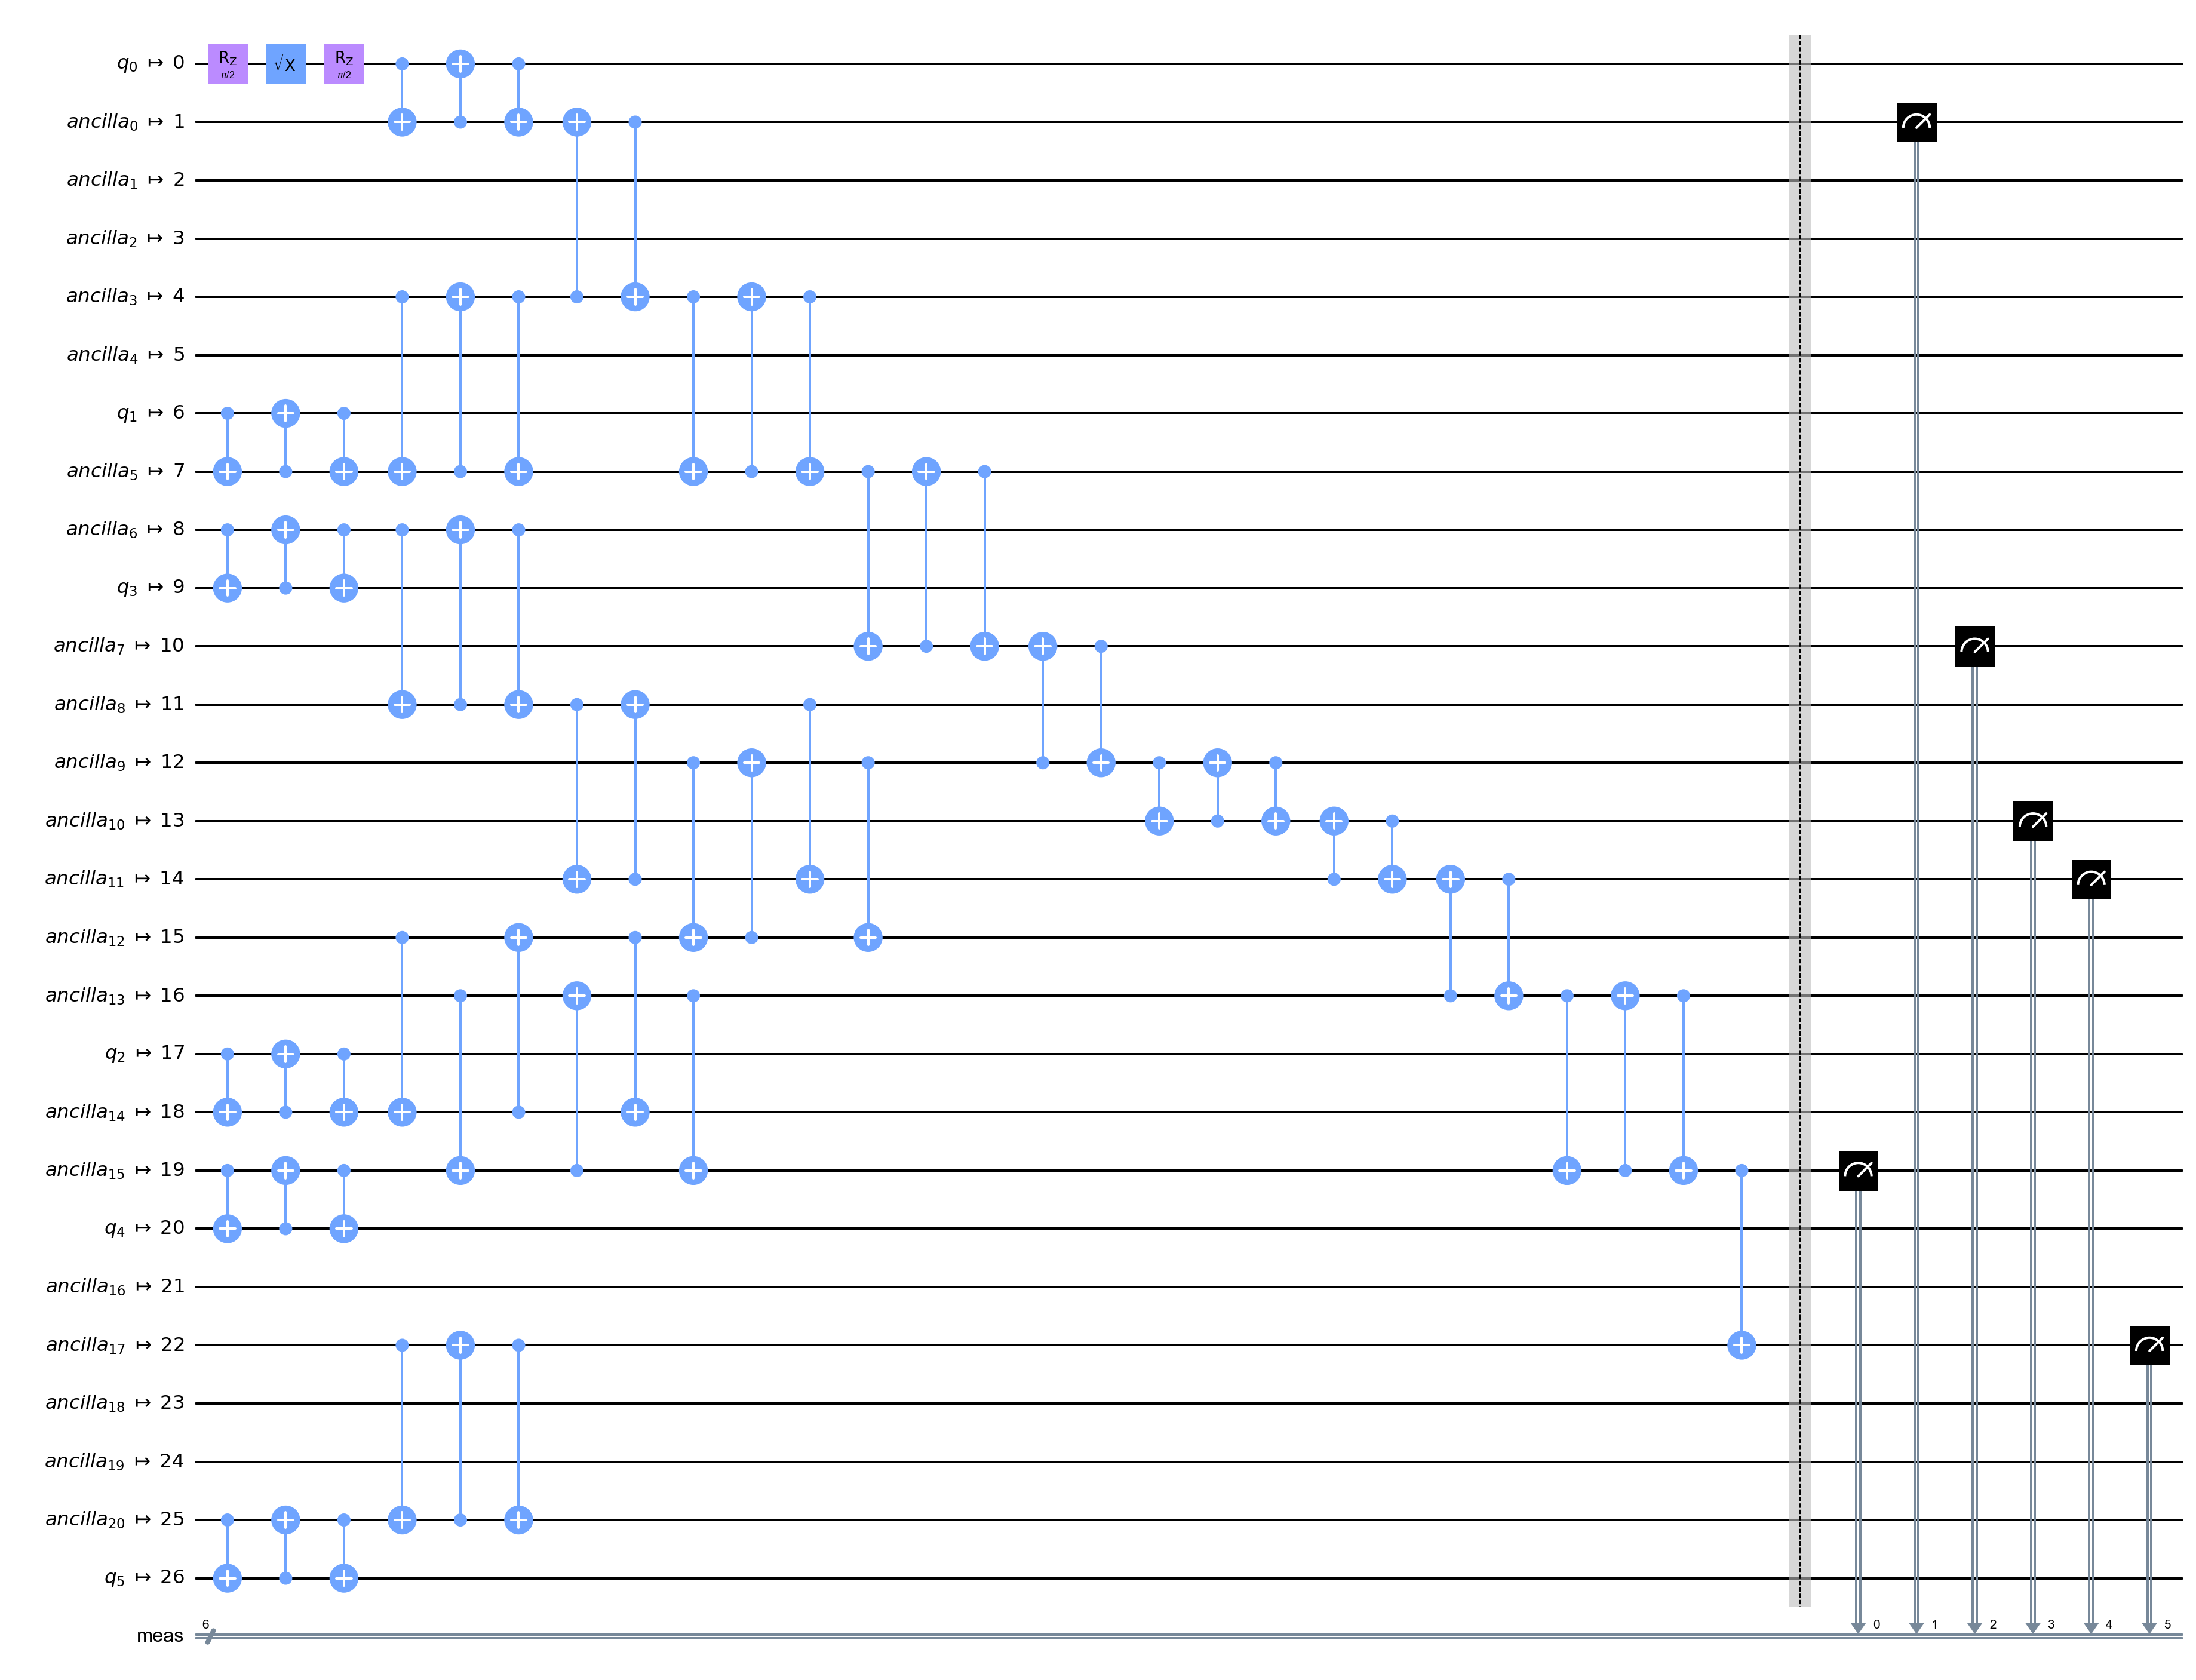

In [11]:
trans_qc = transpile(qc, backend, initial_layout=[0, 6, 17, 9, 20, 26])
trans_qc.draw('mpl', fold=-1)

### SWAP mapping

One of the most important tasks of circuit transpilation/compilation is in the inserting of `swap` gates so as to allow for the limited connectivity of many quantum processors. `cx` gates can only be done between those pairs of qubits listed in the systems coupling map:

In [12]:
print(backend.configuration().coupling_map)

[[0, 1], [1, 0], [1, 2], [1, 4], [2, 1], [2, 3], [3, 2], [3, 5], [4, 1], [4, 7], [5, 3], [5, 8], [6, 7], [7, 4], [7, 6], [7, 10], [8, 5], [8, 9], [8, 11], [9, 8], [10, 7], [10, 12], [11, 8], [11, 14], [12, 10], [12, 13], [12, 15], [13, 12], [13, 14], [14, 11], [14, 13], [14, 16], [15, 12], [15, 18], [16, 14], [16, 19], [17, 18], [18, 15], [18, 17], [18, 21], [19, 16], [19, 20], [19, 22], [20, 19], [21, 18], [21, 23], [22, 19], [22, 25], [23, 21], [23, 24], [24, 23], [24, 25], [25, 22], [25, 24], [25, 26], [26, 25]]


and `swap` gates must be added to move the states of qubits around so that they match one of these coupling edges.

A `swap` gate is equal to 3 `cx` gates, and each `cx` is ~20x more noisy than 1Q gates; `swap` gates are expensive, should be minimized as best as possible.

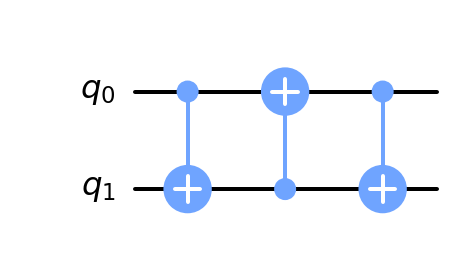

In [13]:
swap_qc = QuantumCircuit(2)
swap_qc.swap(0,1)
swap_qc.decompose().draw('mpl')

Finding the minimum number of `swap` gates needed for a general circuit and system topology is NP-Hard; It becomes combinatorics and scales exponentially.  To get around this the primary SWAP mappers in Qiskit use stochastic heuristics that yield a good, but perhaps not ideal, SWAP mapping.

The default Qiskit SWAP mapper models the system topology as an adjacency graph, upon which the edge weights of the graph are drawn from a randomly sampled normal distribution.

<img src="imgs/default_swap.png" width=800 height=400 />

This breaks the degeneracy of multiple paths, and gives a unique minimum value at the cost of making the SWAP mapping routine stochastic in nature.  In practice this means that the output from `transpile` is not unique, and that repeated transpilation may be required to find the lowest cost SWAP mapping.

Lets transpile our circuit multiple times and look to see how many `swap` gates are added each time.  Additionally, we will look to see if our custom `initial_layout` works any better.  To make sure the `swap` gates are not converted to 3 `cx` gates each time, we will add `swap` to the basis gates (this will not run on hardware).

In [14]:
trans_qcs = transpile([qc]*100, backend, basis_gates=backend.configuration().basis_gates+['swap'])

In [15]:
trans_qcs_init = transpile([qc]*100, backend, basis_gates=backend.configuration().basis_gates+['swap'],
                           initial_layout=[1, 0, 4, 2, 7, 3])

In [16]:
swap_count = [circ.count_ops()['swap'] for circ in trans_qcs]
swap_count_init = [circ.count_ops()['swap'] for circ in trans_qcs_init]

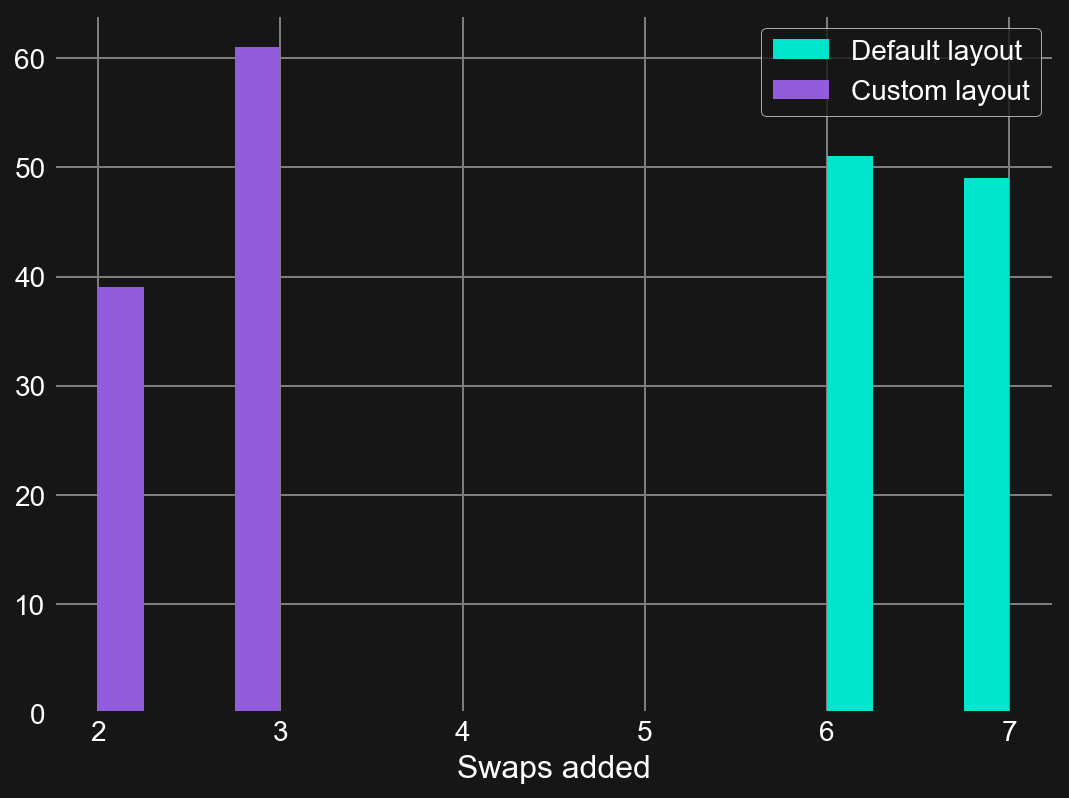

In [17]:
plt.hist(swap_count, bins=4, label='Default layout')
plt.hist(swap_count_init, bins=4, label='Custom layout')
plt.xlabel('Swaps added');
plt.legend();

We see that there is a distribution in terms of the number of added `swap` gates, and that by being a bit smarter in our choice of `initial_layout` we were able to bring the number down.

What does this mean in practice?  

1. To get the best circuit one should transpile multiple times and take the circuit with the shortest depth.

In [18]:
trans_qcs_init = transpile([qc]*100, backend, basis_gates=backend.configuration().basis_gates,
                            initial_layout=[1, 0, 4, 2, 7, 3])

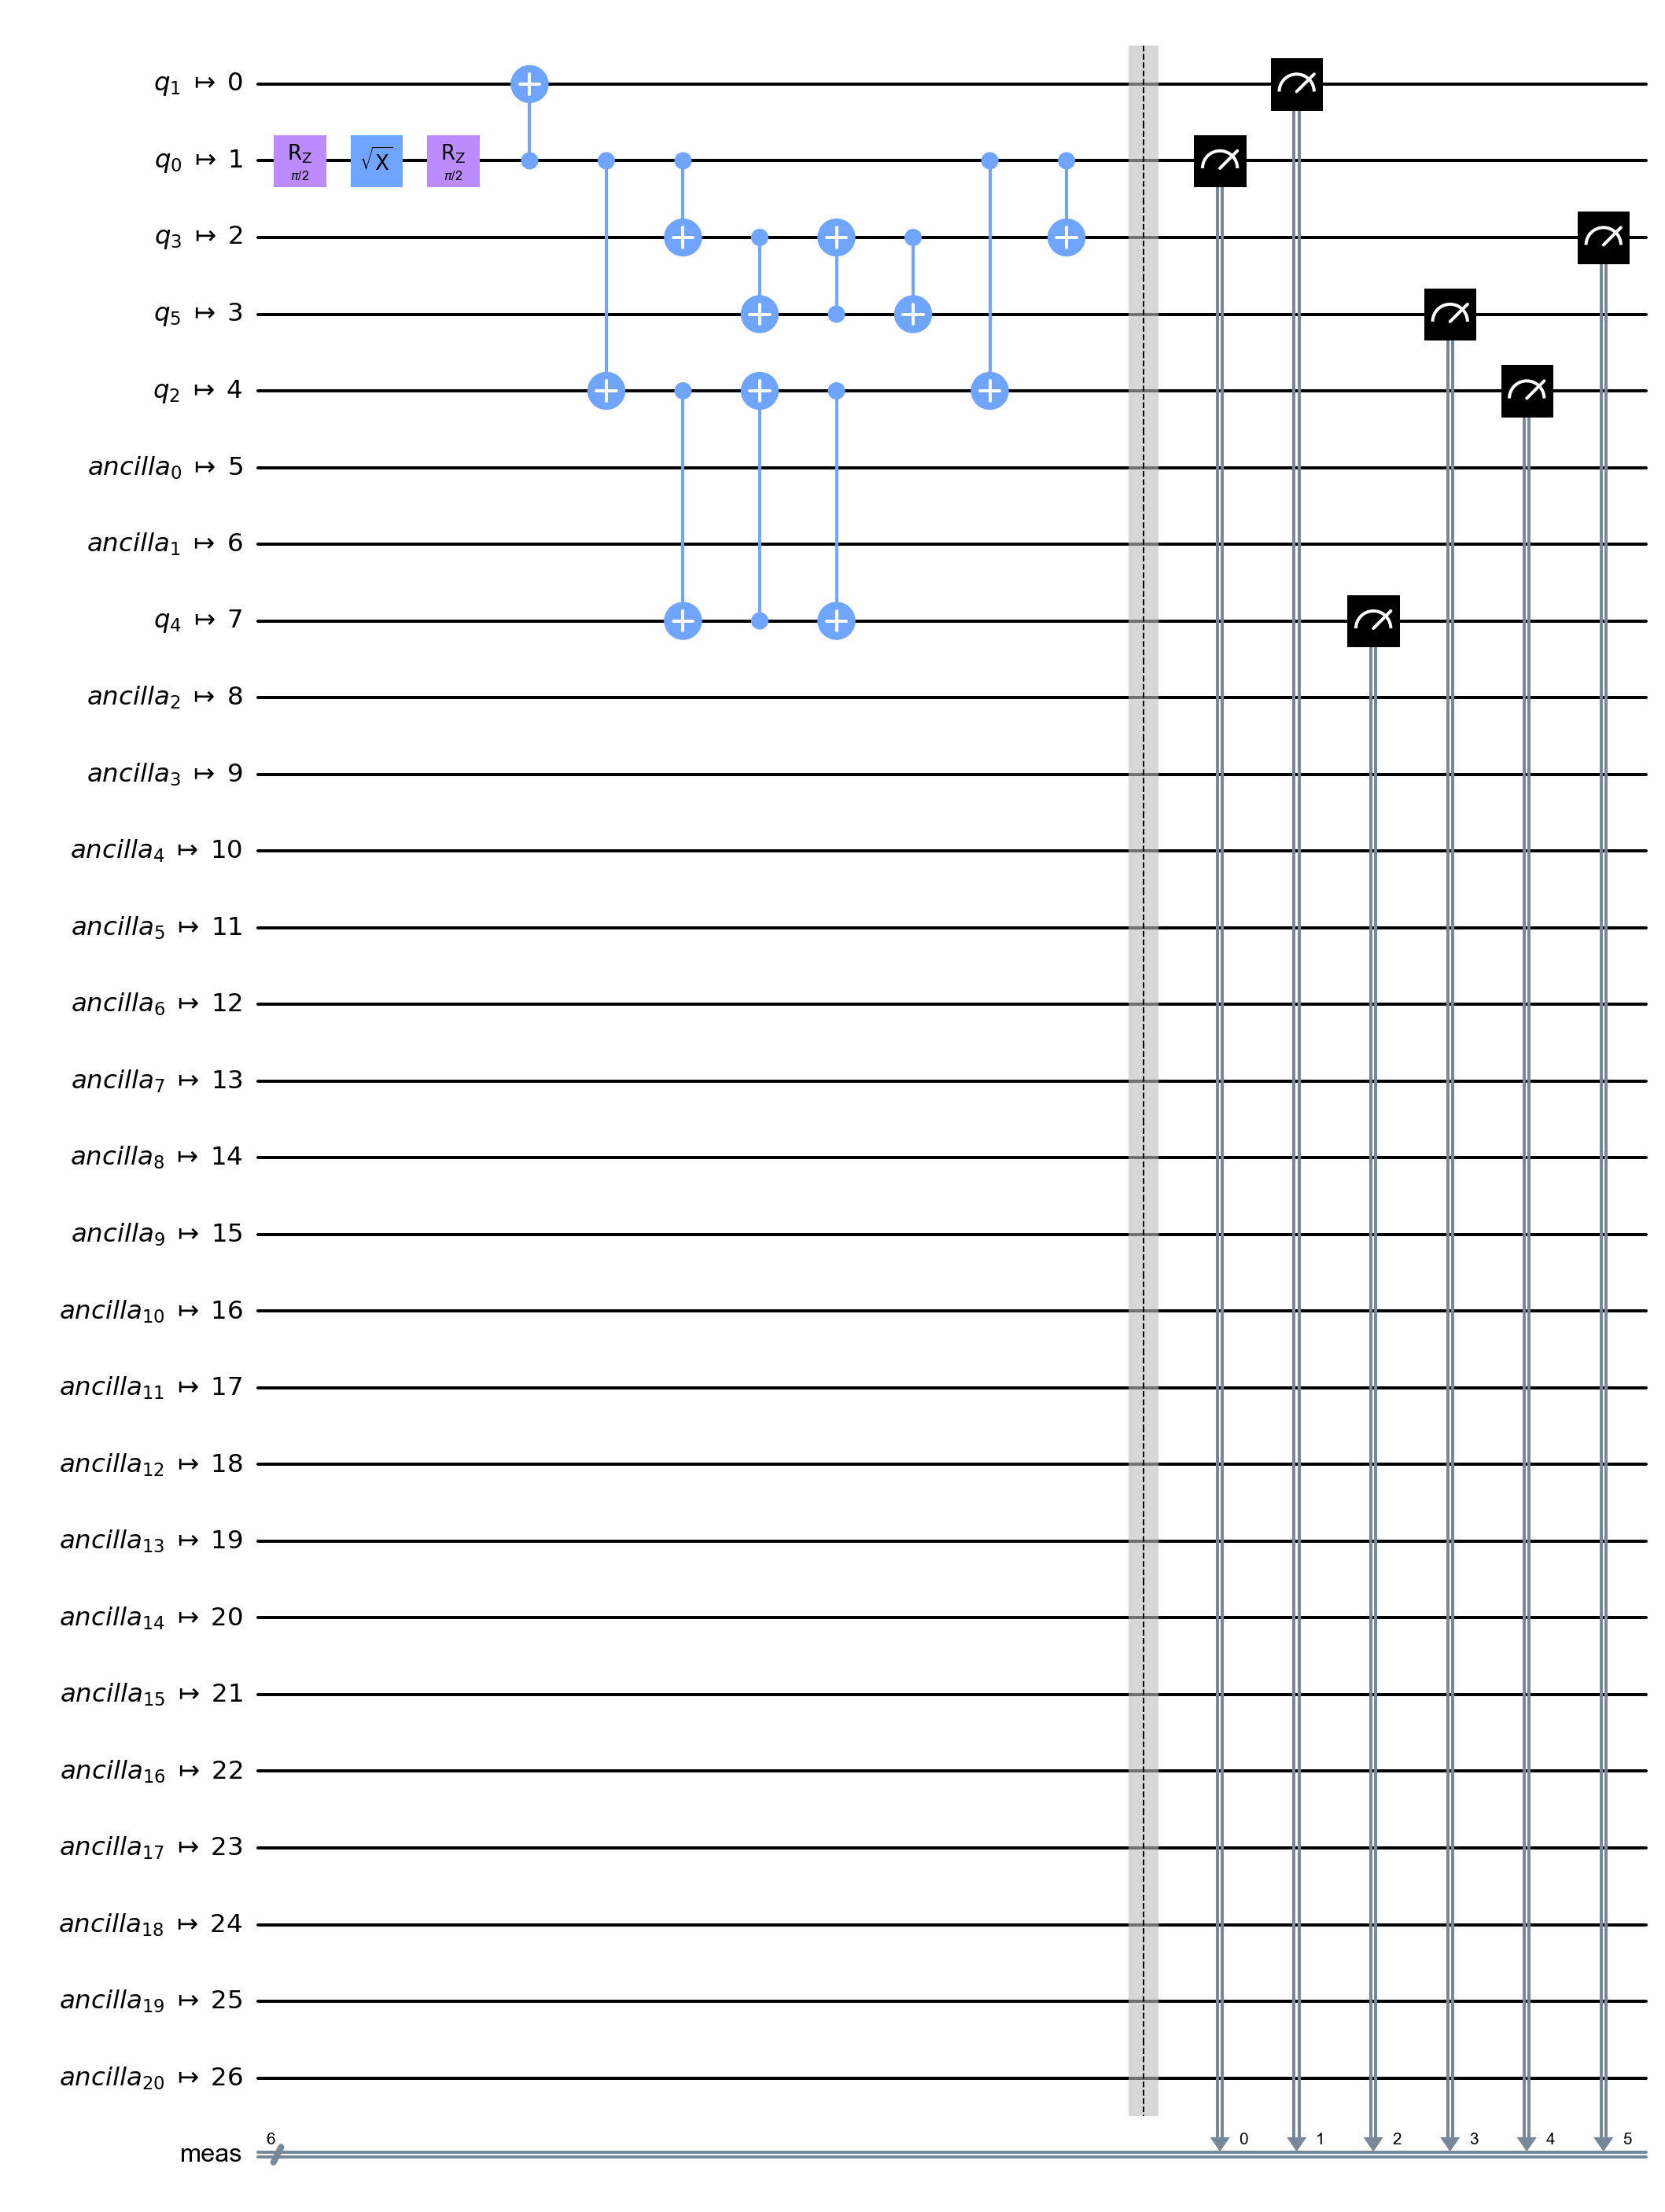

In [19]:
depths = np.array([circ.depth() for circ in trans_qcs_init])
idx = np.where(depths == min(depths))[0][0]
best_qc = trans_qcs_init[idx]
best_qc.draw('mpl', fold=-1)

2. For repeatibility the best circuit can be saved  Or instead, one can transpile multiple times fixing the `seed_transpiler` option with a list of specified integers.  The integer seeds the random number generator used by the SWAP mapper, and allows you to reproduce the circuit again.

In [20]:
seeds = list(range(100))

min_depth = 1e99
best_circ = None
best_seed = None
for kk in range(100):
    trans_qc_seeded = transpile(qc, backend, basis_gates=backend.configuration().basis_gates,
                                 initial_layout=[1, 0, 4, 2, 7, 3], seed_transpiler=seeds[kk])
    temp_depth = trans_qc_seeded.depth()
    if temp_depth < min_depth:
        min_depth = temp_depth
        best_seed = seeds[kk]
        best_circ = trans_qc_seeded

In [21]:
best_seed

3

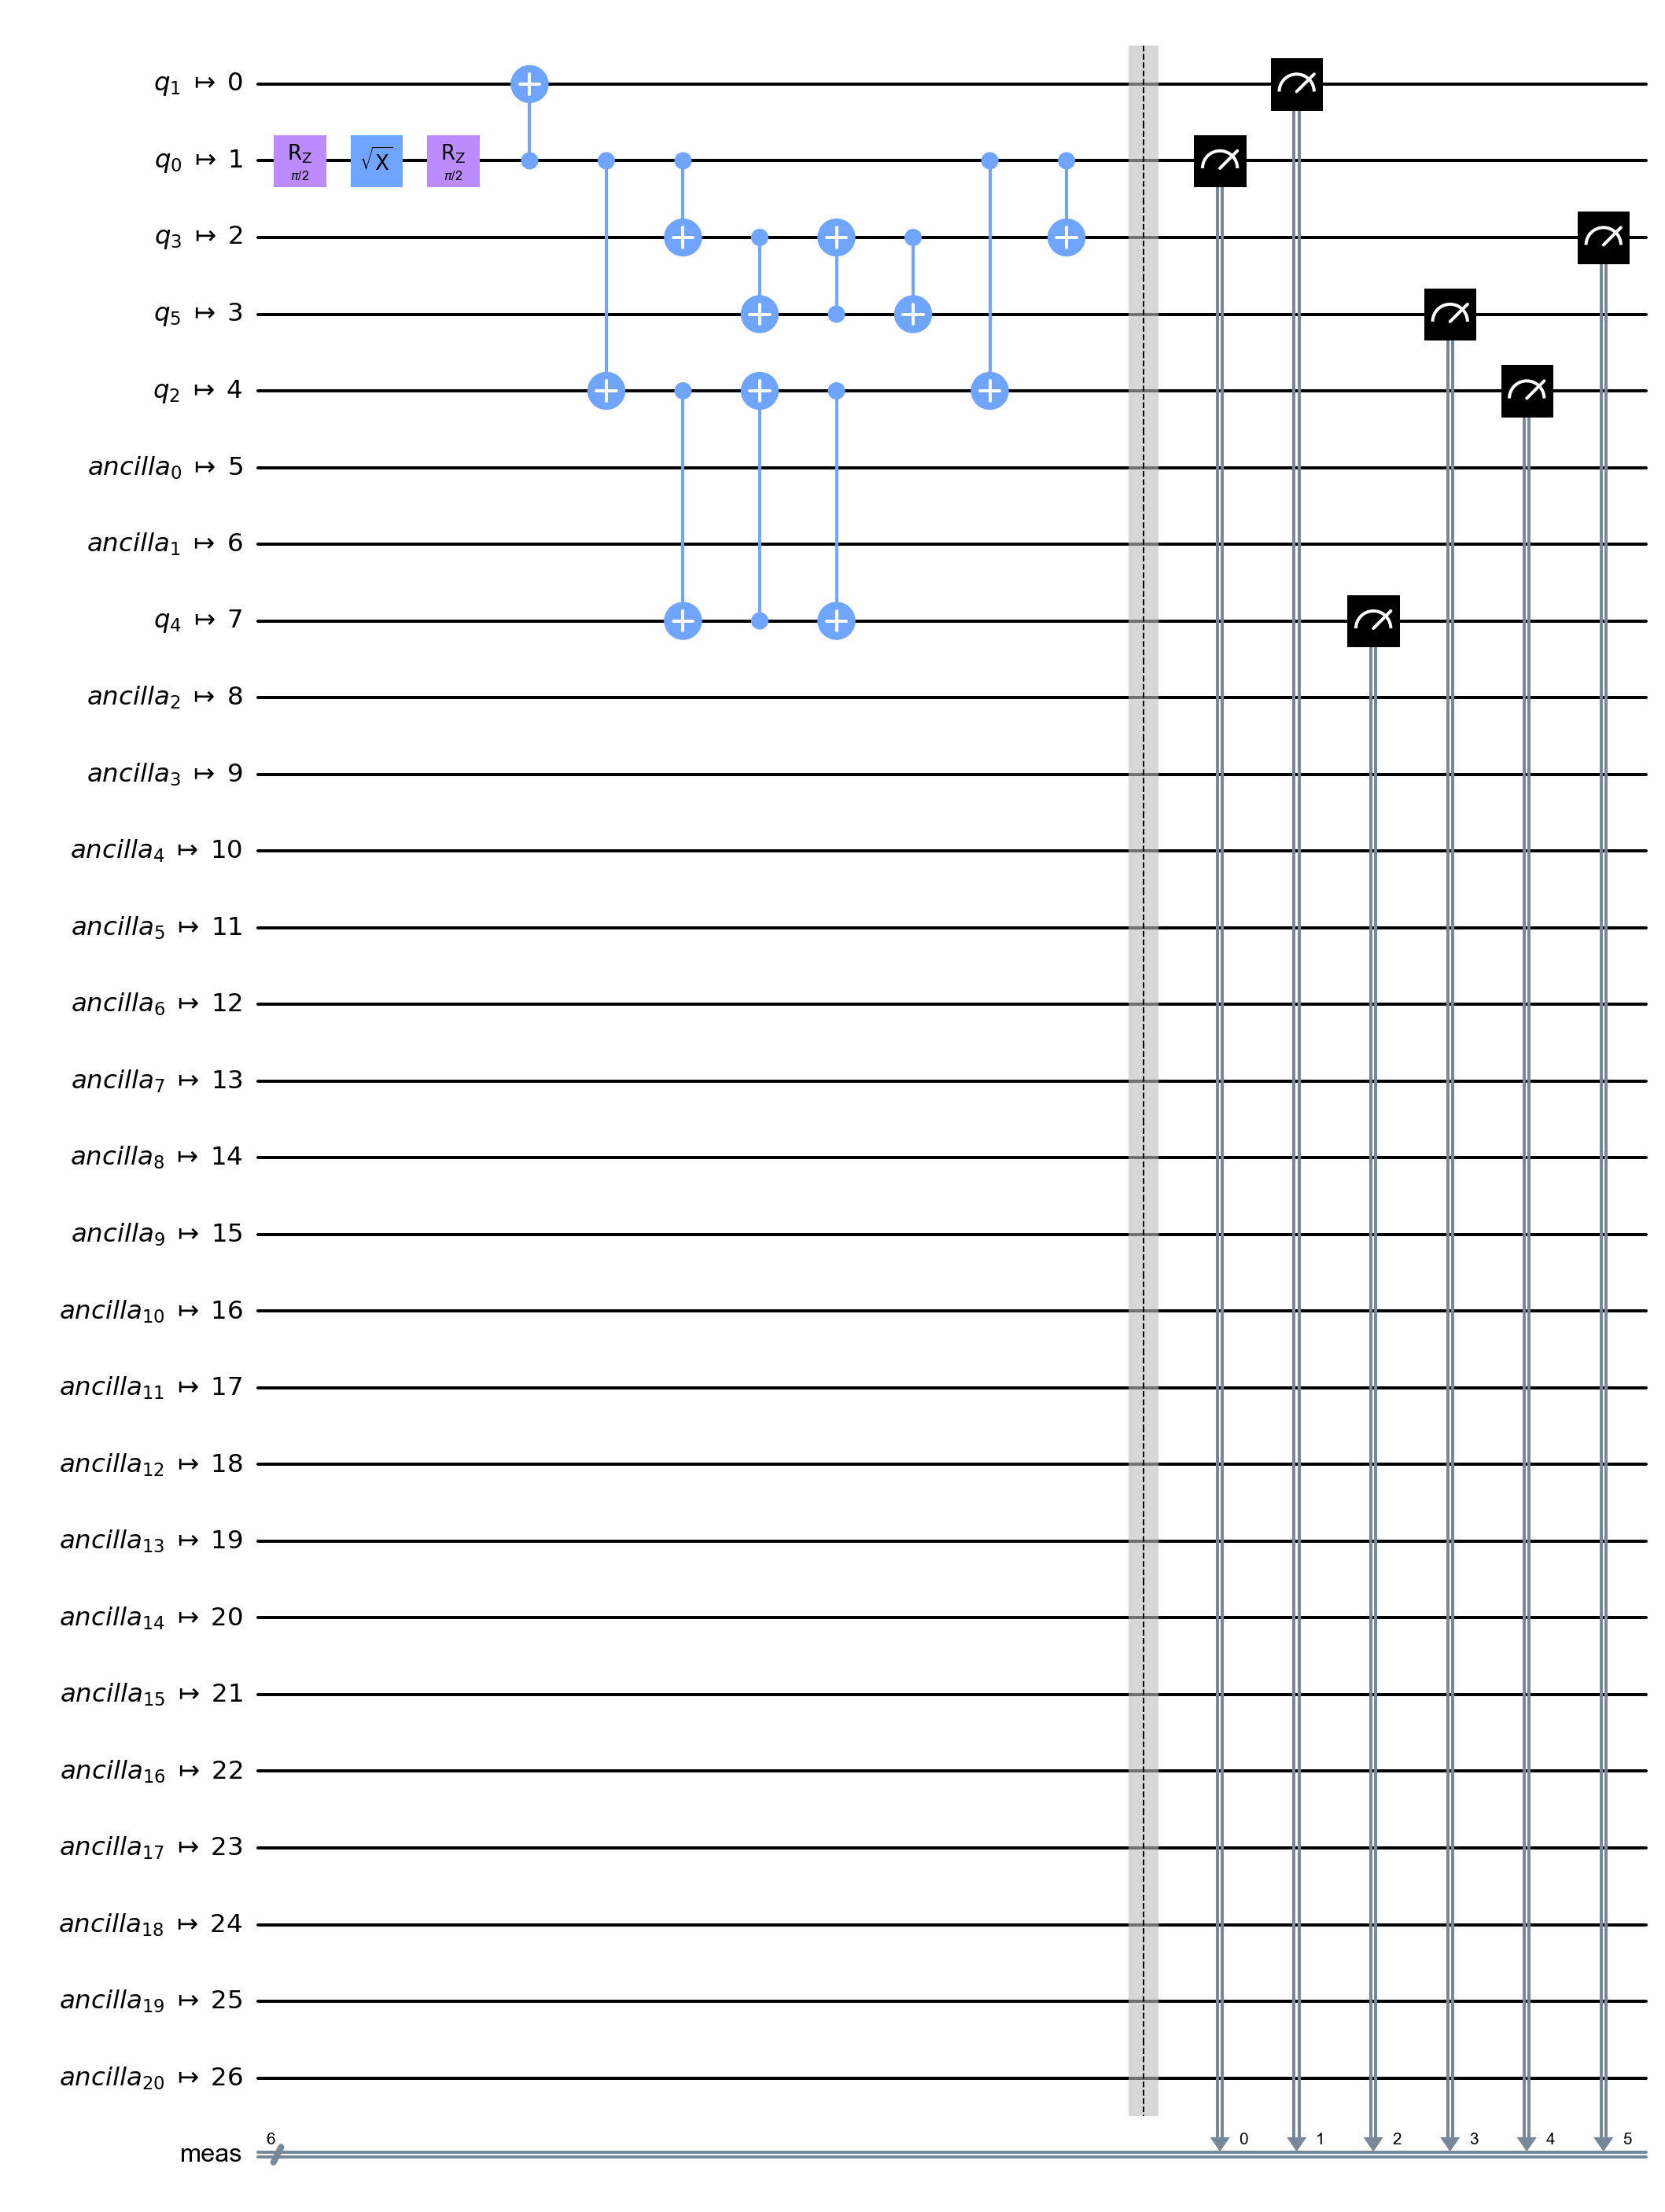

In [22]:
 best_circ.draw('mpl', fold=-1)

Once the `best_seed` value is found we can then use that to deterministically regenerate the optimal circuit.

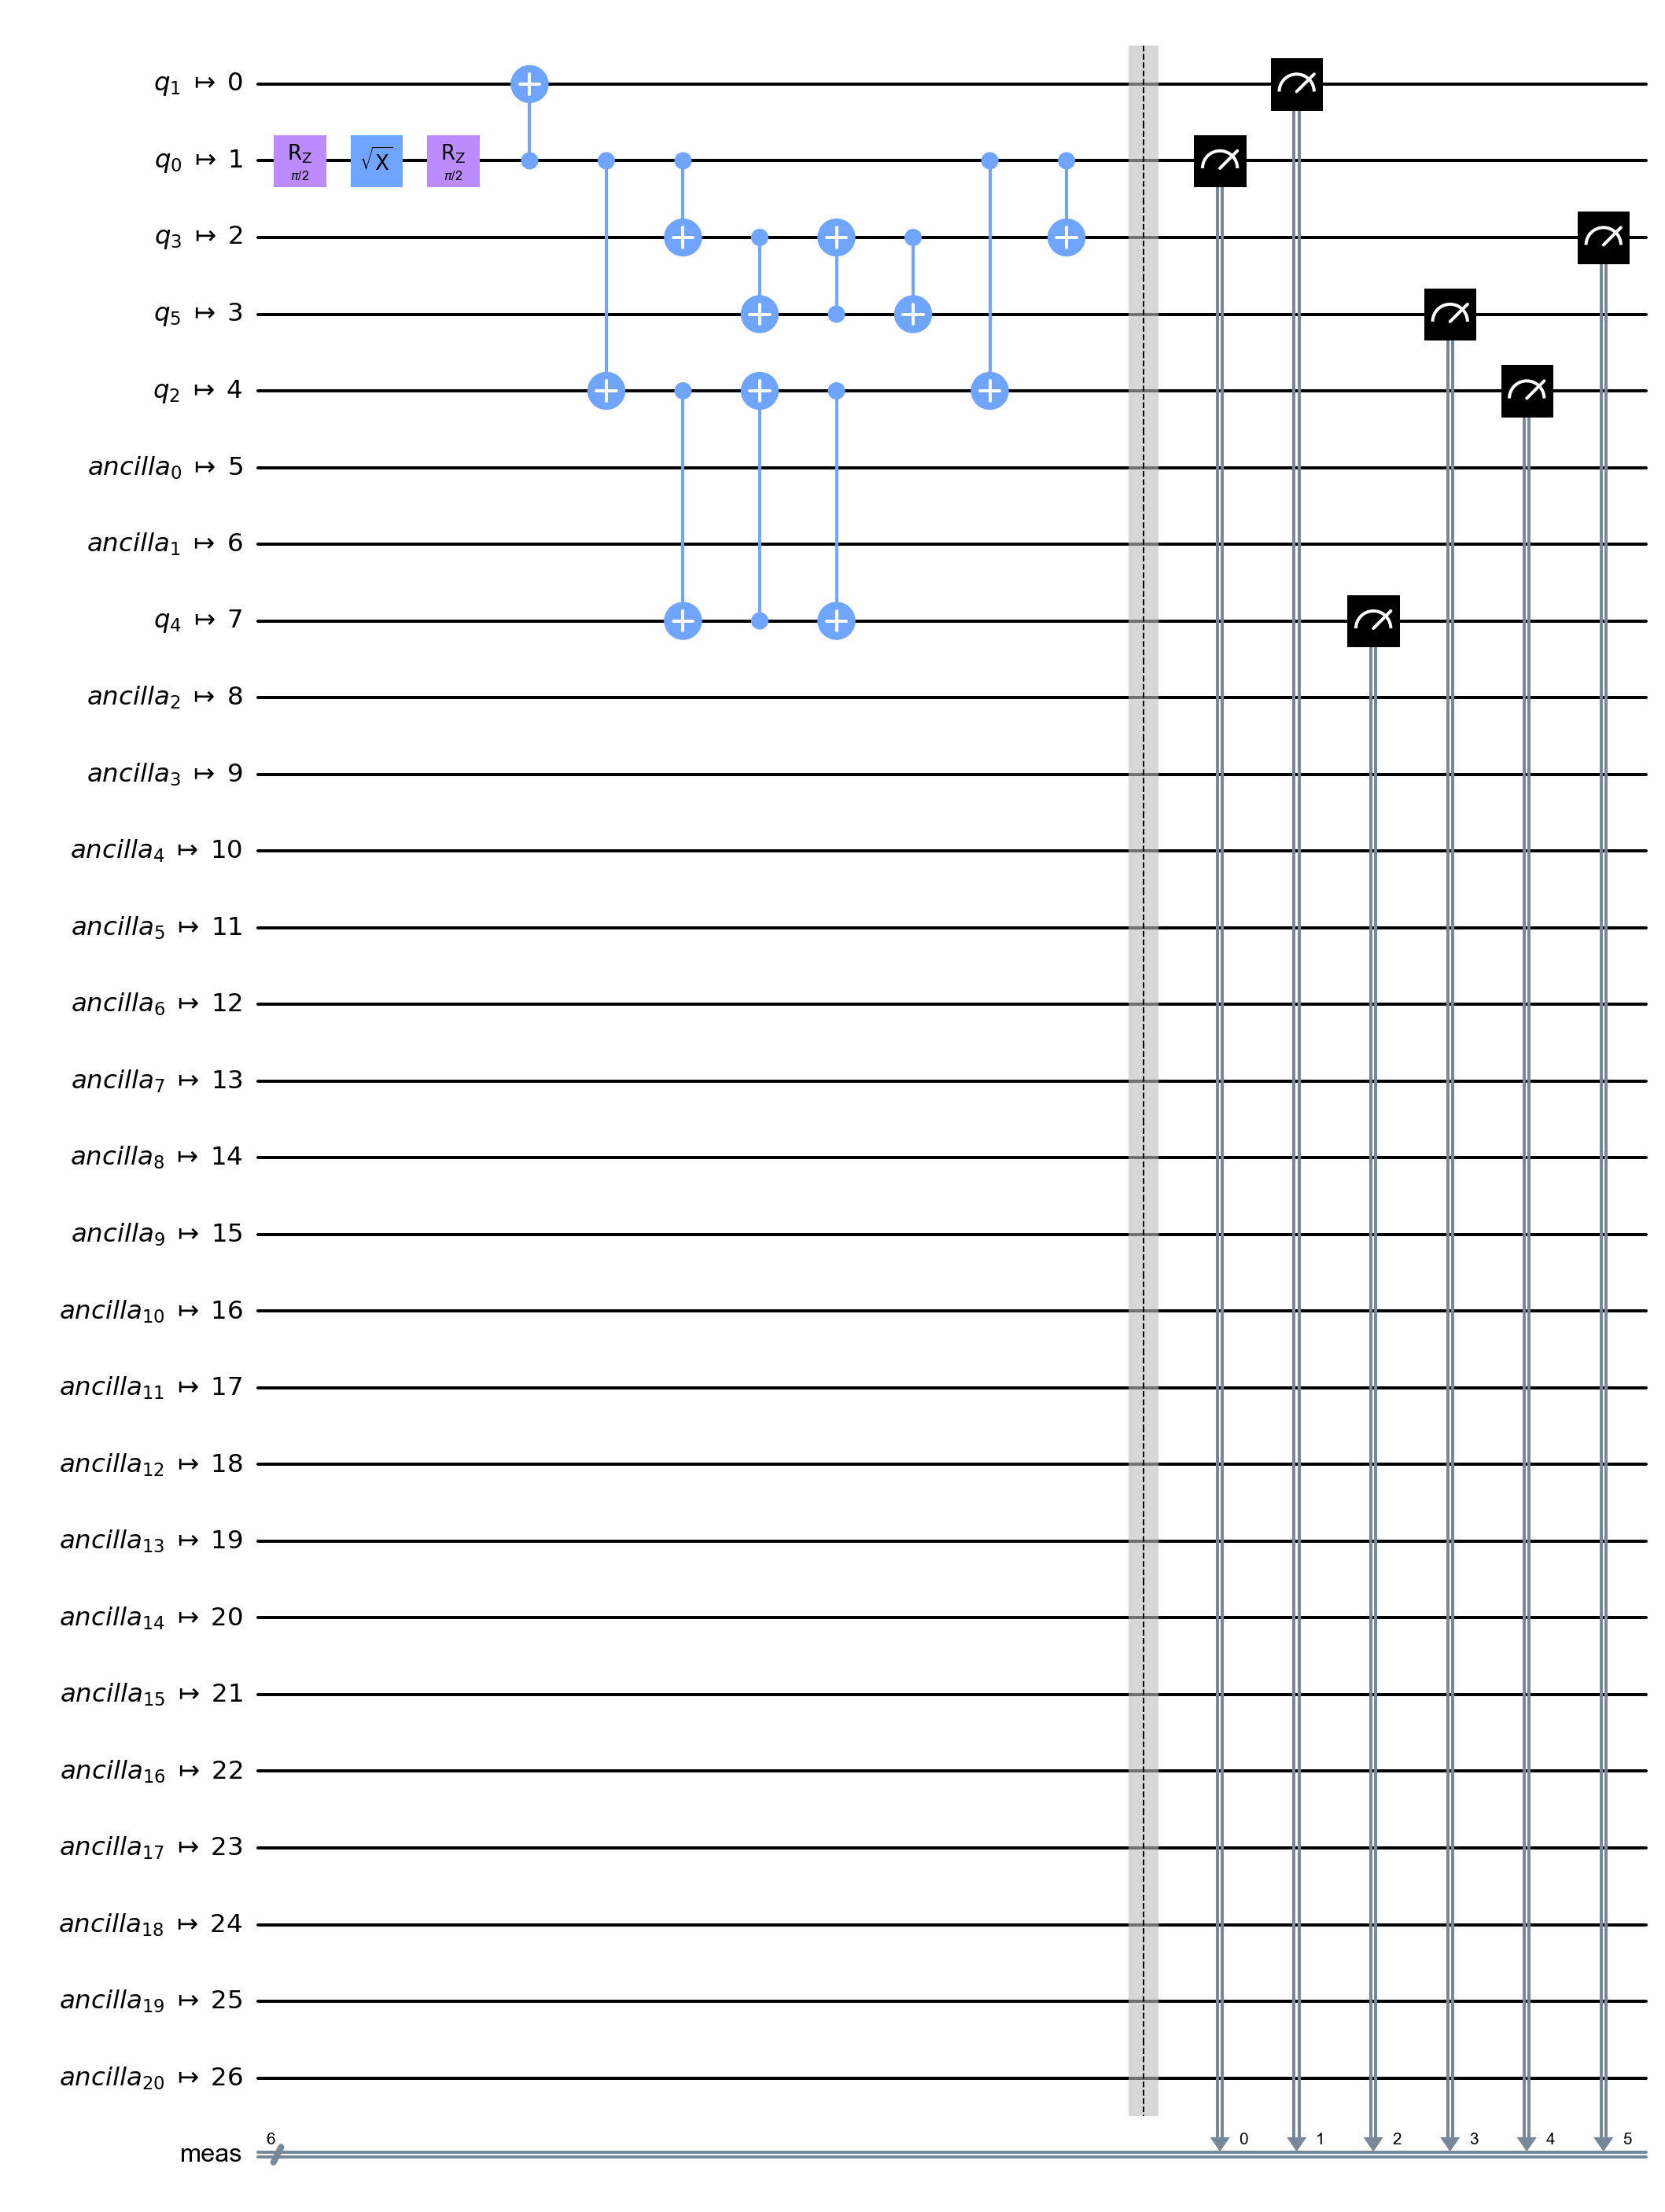

In [23]:
transpile(qc, backend, basis_gates=backend.configuration().basis_gates,
          initial_layout=[1, 0, 4, 2, 7, 3], seed_transpiler=best_seed).draw('mpl', fold=-1)

##  Setting the level of optimization

Much like standard compiler toolchains where one can specific the level of code optimization, e.g. `-O3`, it is possible to specify the level of quantum circuit optimization that `transpile` performs via the `optimization_level` keyword argument where the level is specified by an integer from 0 to 3.  The basic overview of each option is as follows: 

### `optimization_level=0`

1. Convert to target basis gate set.


2. Choose a trivial layout that maps virtual qubit $i$ to physical qubit $i$.

<div class="alert alert-warning">
$\texttt{optimization_level=0}$ orders qubits sequentially from $0\dots N-1$.  On 27-qubit Falcon systems this ordering is usually very sub-optimal due to the column-based qubit ordering of those systems.
</div>

3. SWAP map with the default Qiskit SWAP mapper.


4. No 1Q or 2Q gate optimization.

### `optimization_level=1`

1. Convert to target basis gate set.


2. Choose a trivial layout that maps virtual qubit $i$ to physical qubit $i$.

<div class="alert alert-warning">
$\texttt{optimization_level=1}$ orders qubits sequentially from $0\dots N-1$.  On 27-qubit Falcon systems this ordering is usually very sub-optimal due to the column-based qubit ordering of those systems.
</div>

3. SWAP map with the default Qiskit SWAP mapper.


4. Basic 1Q and 2Q gate optimizations.

### `optimization_level=2`

1. Convert to target basis gate set.


2. Choose a dense (high-connectivity), low-error, initial qubit layout.


3. SWAP map with the default Qiskit SWAP mapper.


4. Medium 1Q and 2Q gate optimizations, e.g. commutative cancellation.

### `optimization_level=3`

1. Convert to target basis gate set.


2. Select an `initial_layout` based on the Sabre algorithm (not noise aware).


3. SWAP map using the Sabre routing method (not noise aware).


4. Full 1Q and 2Q gate optimizations, e.g. 2Q block collection and consolidation (KAK decomposition) and approximate unitary synthesis.

[Sabre layout and routing](https://arxiv.org/abs/1809.02573) selects a good layout by SWAP mapping the circuit in both the froward and reverse direction using the final SWAP layout as the initial layout of the next iteration.  The first layout selection is random.  SWAP placement is done via a heuristic that penalizes previously used qubits and a random choice of SWAP gates when there is a tie for the cost function.

<div class="alert alert-danger">
$\texttt{optimization_level=3}$ in Qiskit 0.18+ internally uses an implicit approximation for decomposing unitary gates.  These approximations break the notion of unitary equivilence in the transpiler and can lead to invalid results in some cases.
</div>

In [24]:
o3_qc = transpile([qc]*100, backend,
                  basis_gates=backend.configuration().basis_gates+['swap'],
                  optimization_level=3)

In [25]:
o3_swap_count = [circ.count_ops()['swap'] for circ in o3_qc]

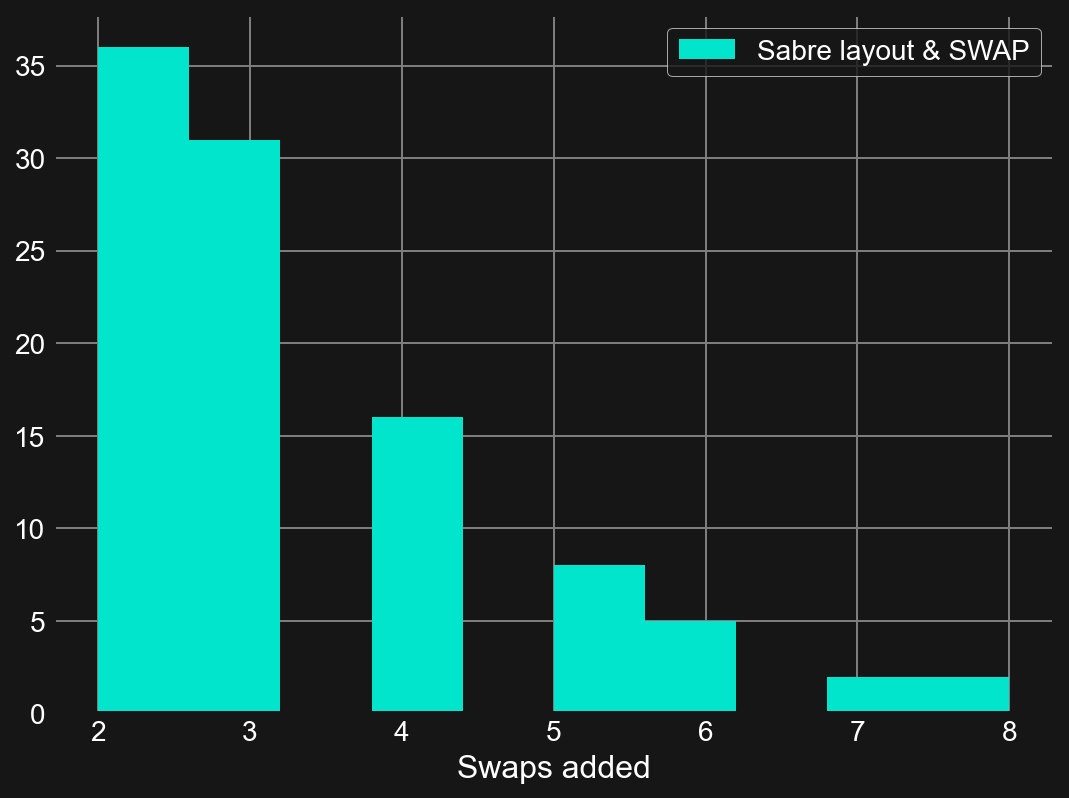

In [26]:
plt.hist(o3_swap_count, bins=10, label='Sabre layout & SWAP')
plt.xlabel('Swaps added');
plt.legend();

## The best general choice for `transpile` options

By default users who do not want, or cannot, map their circuits by hand via `initial_layout` should select `optimization_level=3` in Qiskit `0.19+` or for earlier versions of Qiskit:

```python
transpile(qc, backend, optimization_level=3,
          layout_method='sabre', routing_method='sabre')
```

Additionally, one should transpile a given circuit multiple times (at least ~10) to find the best mapping.  A more in-depth investigation into this can be found in [this blog post](https://nonhermitian.org/posts/2021/2021-10-31-best_swap_mapper_qiskit.html).

## Things NOT to do

The following is a list of things that, in general, one should not set:

1. Never use anything but the default ('stochastic') or `sabre` SWAP mappers.  Other options that can be passed to `routing_method` are `basic` and `lookahead`. `basic` is for learning purposes only, and `lookahead` is not really supported, and will crash and/or take a very long time.


2. Never set `layout_method='noise_adaptive'`.  This routine will attempt to find the best layout based on the noise properties of the system.  However in doing so it greatly increases the number of SWAP gates that are added to the circuit.  The result is usually a large drop in the fidelity of the output.

## Being smarter

Often there is a smarter way to encode a circuit given knowledge of the topology and/or feature set of the system.  In the case of our GHZ state it is possible to rewrite the circuit to match a linear nearest-neighboor topology, and thus require no additonal SWAP gates on most IBM Quantum systems.

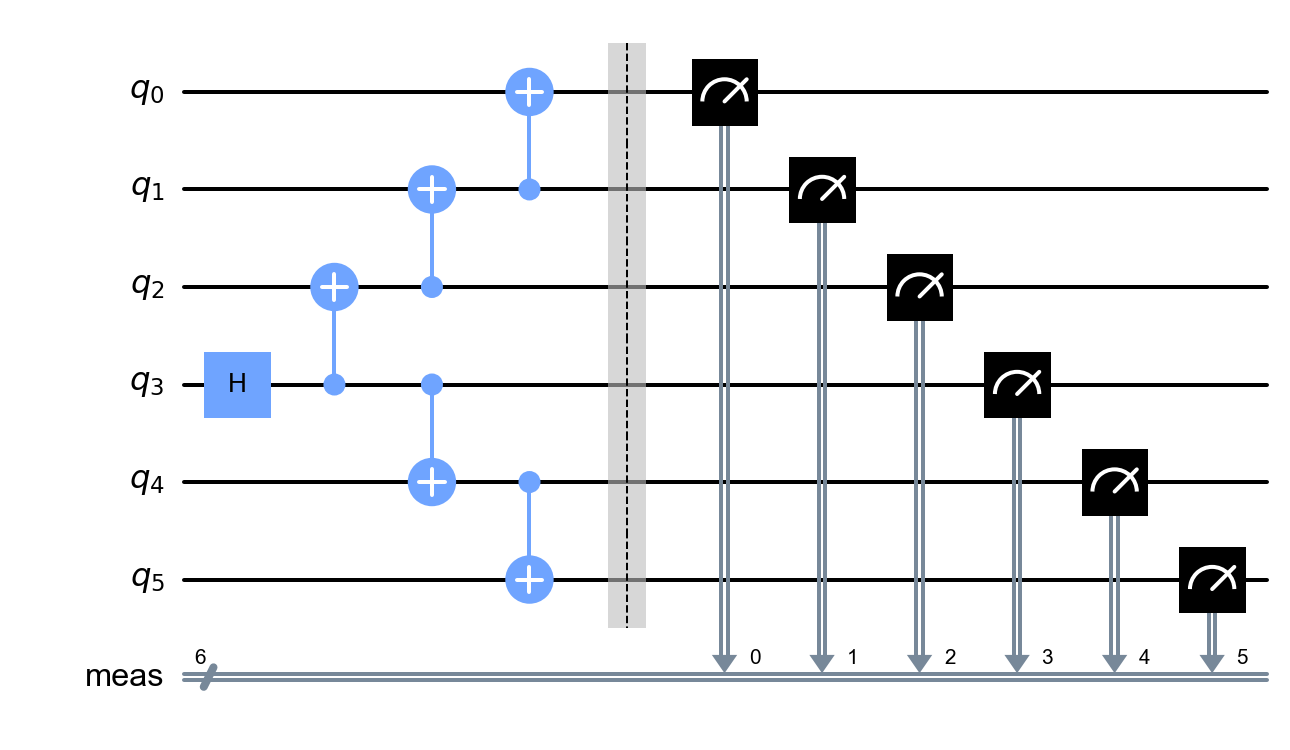

In [27]:
N = 6
qc_smart = QuantumCircuit(N)
qc_smart.h(N//2)
for kk in range(N//2, 0,-1):
    qc_smart.cx(kk,kk-1)
for kk in range(N//2, N-1):
    qc_smart.cx(kk, kk+1)
qc_smart.measure_all()
qc_smart.draw('mpl')

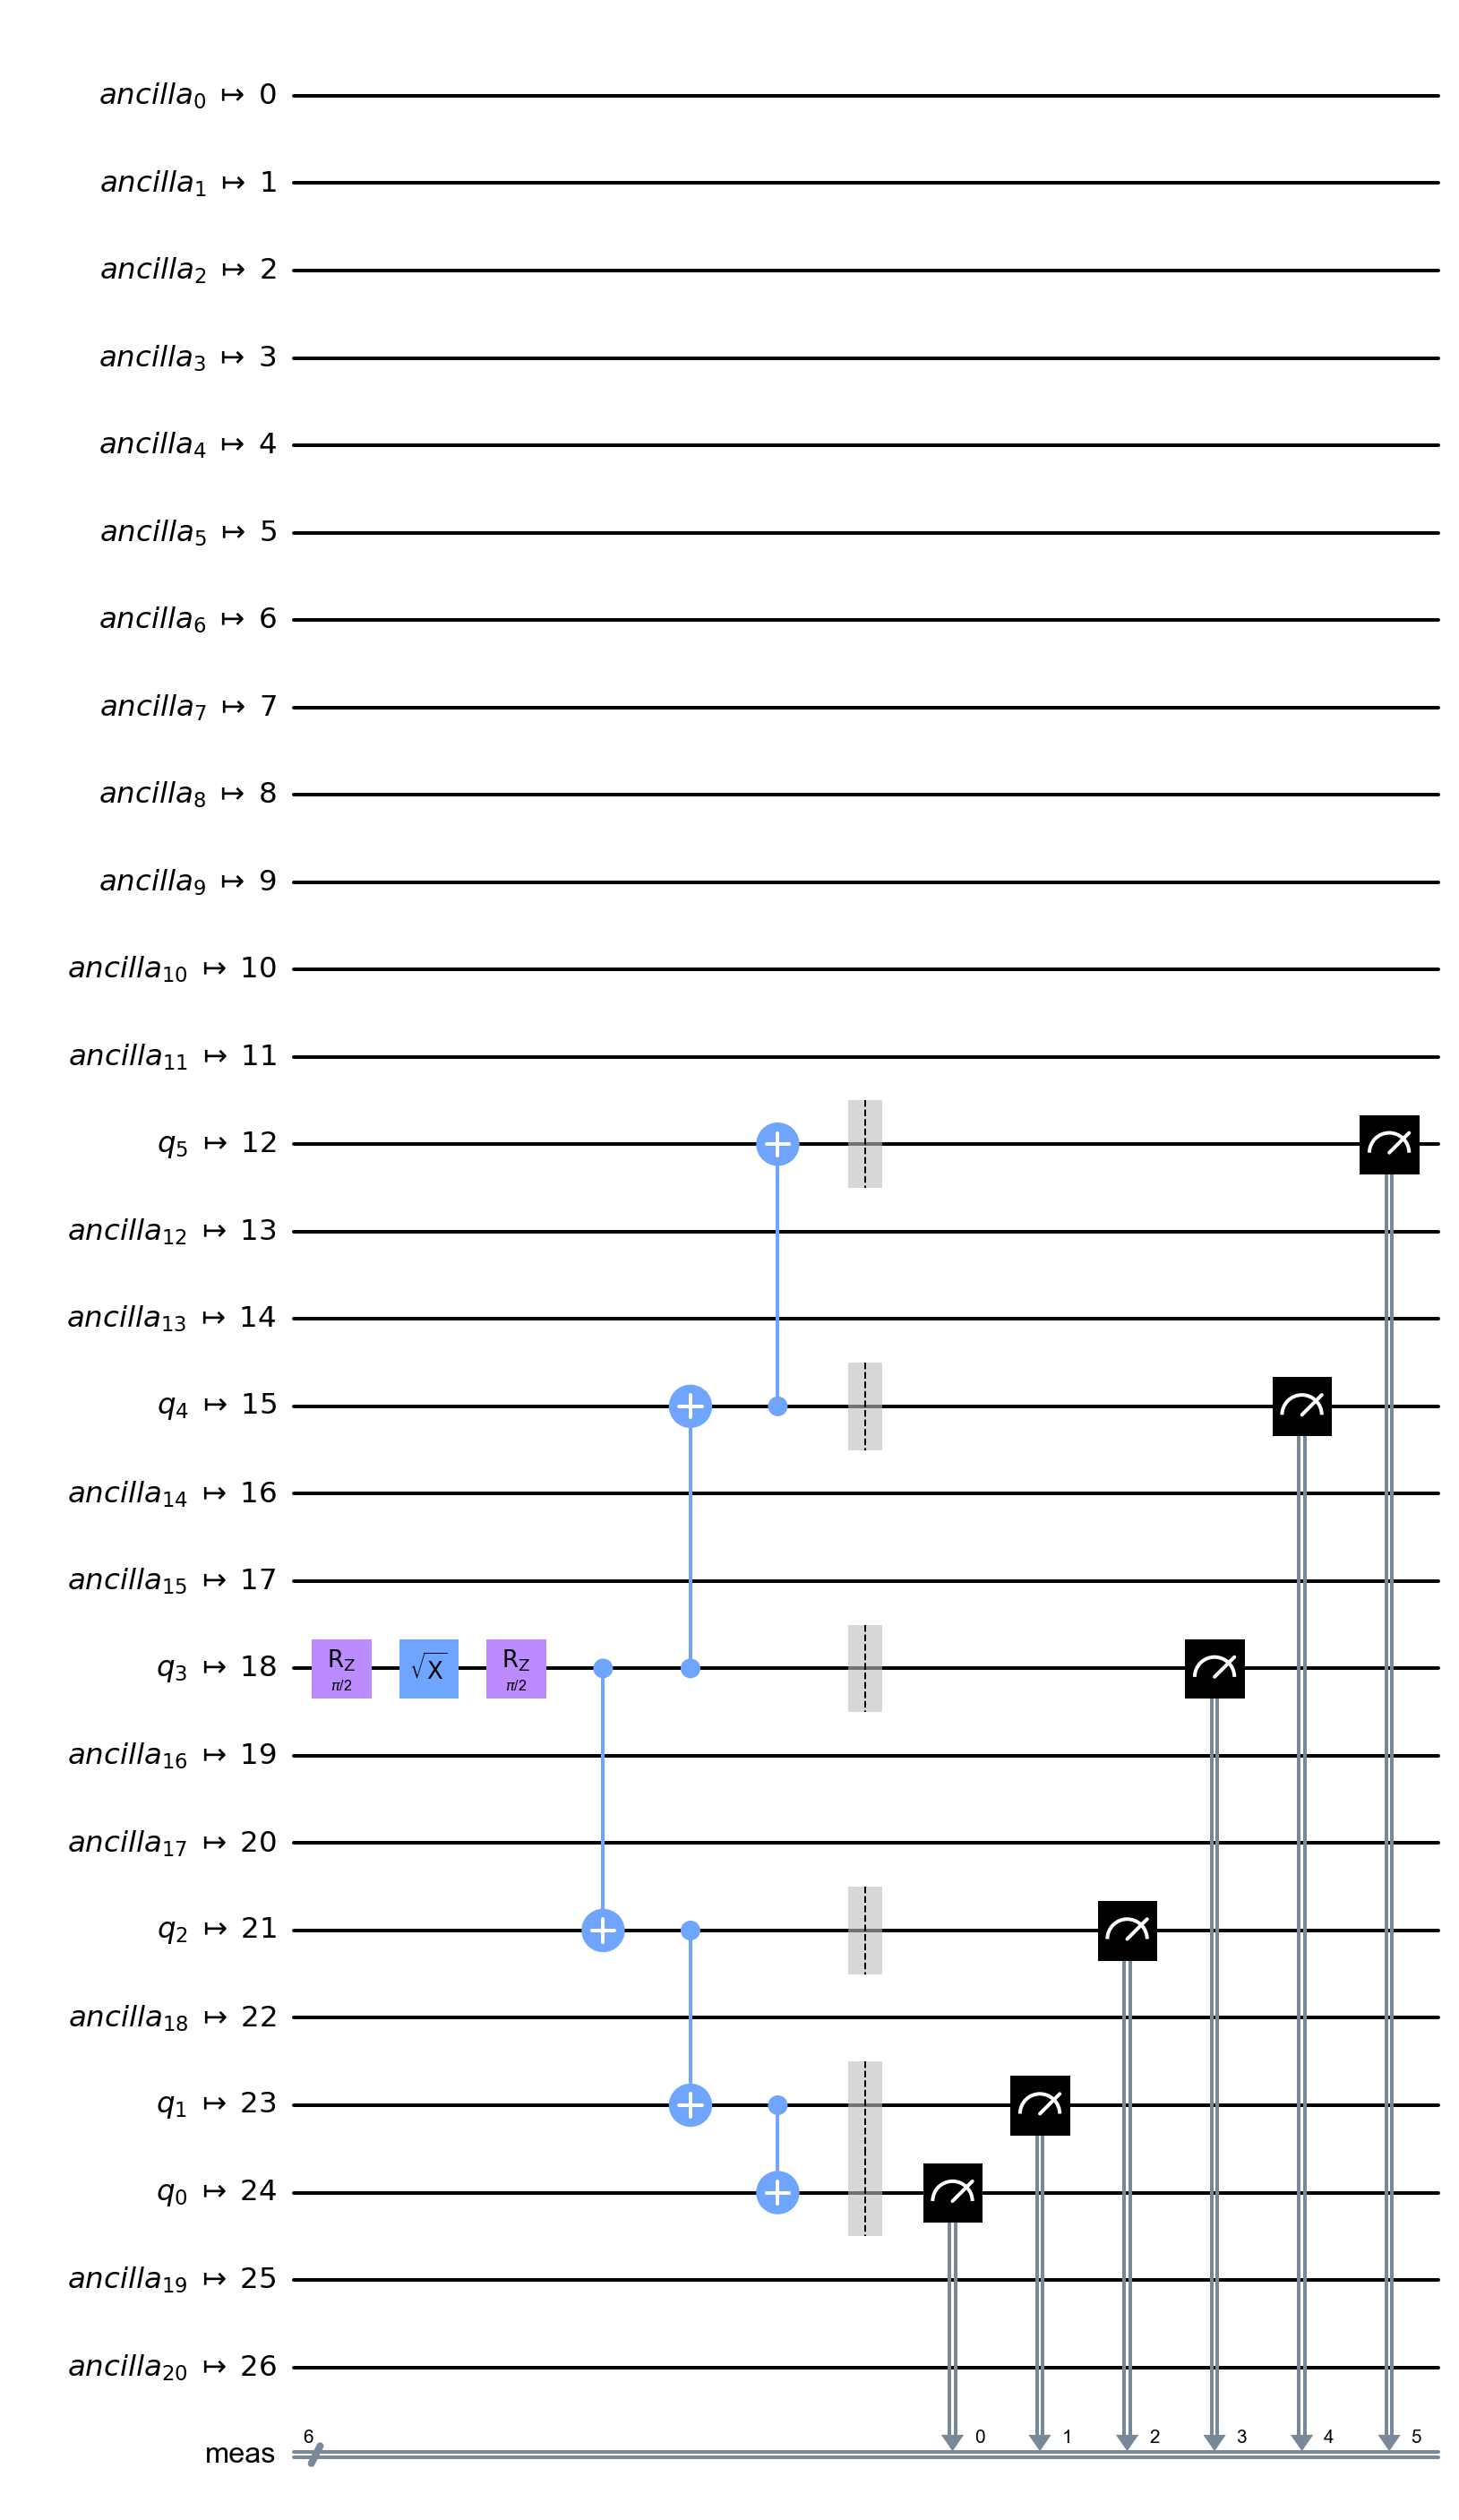

In [28]:
best_qc = transpile(qc_smart, backend, optimization_level=3)
best_qc.draw('mpl', fold=-1)

Unlike the GHZ used throughout this tutorial notebook, the following Bernstein-Vazrani (BV) circuit cannot be written to match the topology.

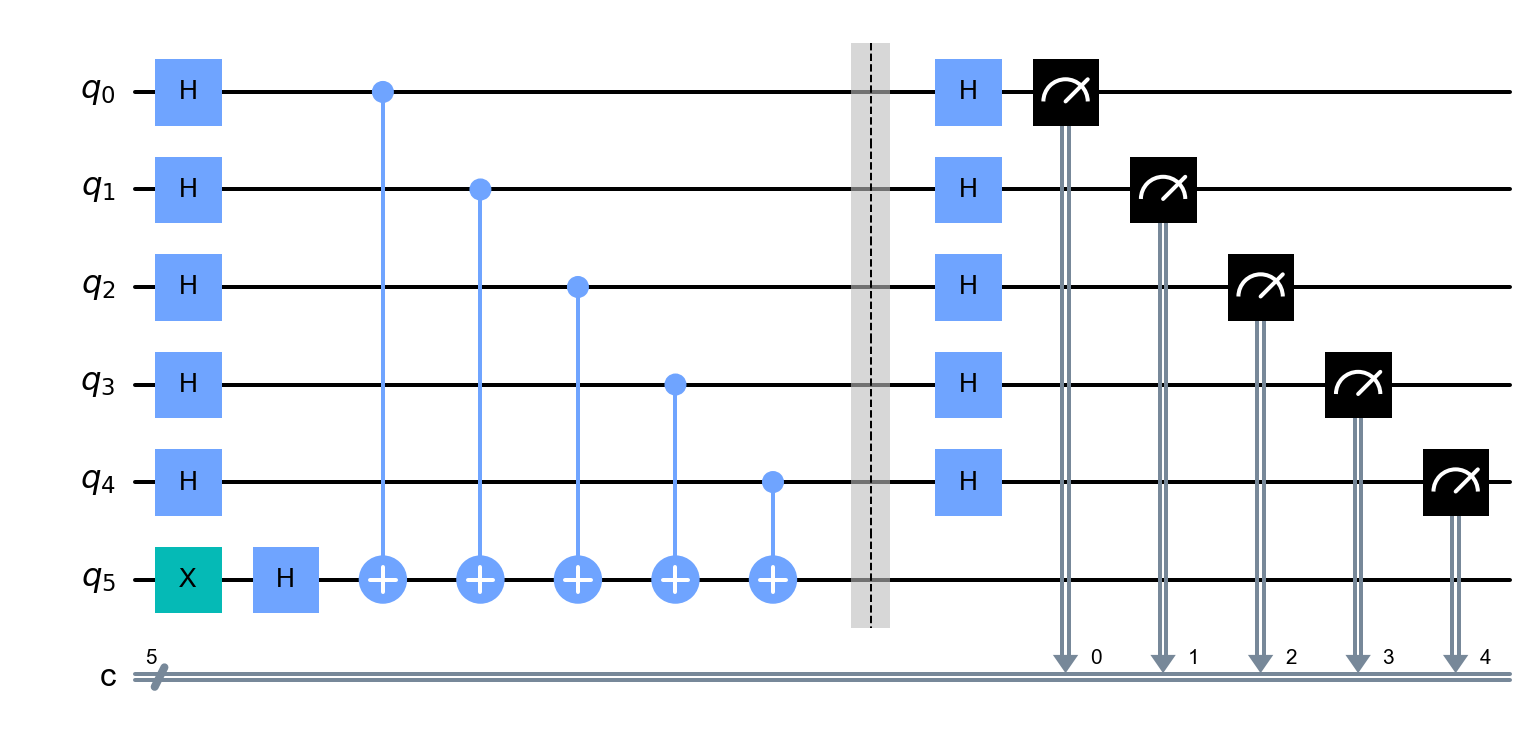

In [29]:
N = 6
qc_bv = QuantumCircuit(N, N-1)
qc_bv.x(N-1)
qc_bv.h(range(N))
qc_bv.cx(range(0,N-1),N-1)
qc_bv.barrier()
qc_bv.h(range(N-1))
qc_bv.measure(range(N-1), range(N-1))
qc_bv.draw('mpl')

However, because the BV circuit uses phase kickback that leaves the target qubit unentangled, the circuit is really comprised of only two qubit interactions, and could be greatly simplified if we are able to measure and reset qubits.  Fortunetly IBM Quantum systems can do this, and one can rewrite this circuit as a [dynamic BV circuit](https://nonhermitian.org/posts/2021/2021-10-27-dynamic_BV.html).

The point we are trying to drive here is that, at this stage of quantum computing, there is great benefit in understanding what type of circuits one is running and how they can best be written to match the topology of the target system and its capabilities.

In [30]:
import qiskit.tools.jupyter
%qiskit_version_table